In [ ]:
# pip install imbalanced-learn
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu

from sklearn.preprocessing import StandardScaler
import pickle
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, learning_curve
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from lightgbm import plot_importance

In [ ]:
def get_classification_report(y_train_true, y_train_pred, y_valid_true, y_valid_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('VALID\n\n' + classification_report(y_valid_true, y_valid_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_valid_true, y_valid_pred))

# 1. Построение модели классификации

**Пути к директориям и файлам**

In [ ]:
TRAIN_DATASET_PATH = './course_project_train.csv'
TEST_DATASET_PATH = './course_project_test.csv'
PREP_TRAIN_PATH = './prepared_train.csv'
SCALER_FILE_PATH = './scaler.pkl'
FULL_NORM_PATH = './full_normalized_train.csv'
BALANCED_TRAIN_PATH = './balanced_train.csv'
VALID_PATH = './valid.csv'

## 1.1. Обзор обучающего датасэта

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### 1.1.1. Загрузка данных

In [ ]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [ ]:
train_df.shape

(7500, 17)

In [ ]:
train_df.iloc[0]

Home Ownership                            Own Home
Annual Income                             482087.0
Years in current job                           NaN
Tax Liens                                      0.0
Number of Open Accounts                       11.0
Years of Credit History                       26.3
Maximum Open Credit                       685960.0
Number of Credit Problems                      1.0
Months since last delinquent                   NaN
Bankruptcies                                   1.0
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                     99999999.0
Current Credit Balance                     47386.0
Monthly Debt                                7914.0
Credit Score                                 749.0
Credit Default                                   0
Name: 0, dtype: object

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

### 1.1.2. Приведение типов

In [ ]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    # df['Home Ownership'] = df['Home Ownership'].astype('category')      после объединения категорий
    # df['Annual Income'] = df['Annual Income'].astype('uint32')      сначала нужно обработать пропуски
    years_mapping = {
        '< 1 year': 0.5,
        '1 year': 1,
        '2 years': 2,
        '3 years': 3,
        '4 years': 4,
        '5 years': 5,
        '6 years': 6,
        '7 years': 7,
        '8 years': 8,
        '9 years': 9,
        '10+ years': 10
    }
    for i in range(len(df)):
        year = df['Years in current job'][i]
        if year in years_mapping:
            df.loc[i, 'Years in current job'] = years_mapping[year]
        else:
            df.loc[i, 'Years in current job'] = 0
    df['Years in current job'] = df['Years in current job'].astype('float16')
    df['Tax Liens'] = df['Tax Liens'].astype('uint8')
    df['Number of Open Accounts'] = df['Number of Open Accounts'].astype('uint8')
    df['Maximum Open Credit'] = df['Maximum Open Credit'].astype('uint32')
    df['Number of Credit Problems'] = df['Number of Credit Problems'].astype('uint8')
    # df['Months since last delinquent'] = df['Months since last delinquent'].astype('uint8')    сначала нужно обработать пропуски
    # df['Bankruptcies'] = df['Bankruptcies'].astype('uint8')      сначала нужно обработать пропуски
    # df['Purpose'] = df['Purpose'].astype('category')      после объединения категорий
    df['Term'] = df['Term'].astype('category')
    df['Current Loan Amount'] = df['Current Loan Amount'].astype('uint32')
    df['Current Credit Balance'] = df['Current Credit Balance'].astype('uint32')
    df['Monthly Debt'] = df['Monthly Debt'].astype('uint32')
    # df['Credit Score'] = df['Credit Score'].astype('uint16')      сначала нужно обработать пропуски
    df['Credit Default'] = df['Credit Default'].astype('uint8')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [ ]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.57 MB
Decreased by 41.9%


In [ ]:
train_df.dtypes

Home Ownership                    object
Annual Income                    float64
Years in current job             float16
Tax Liens                          uint8
Number of Open Accounts            uint8
Years of Credit History          float64
Maximum Open Credit               uint32
Number of Credit Problems          uint8
Months since last delinquent     float64
Bankruptcies                     float64
Purpose                           object
Term                            category
Current Loan Amount               uint32
Current Credit Balance            uint32
Monthly Debt                      uint32
Credit Score                     float64
Credit Default                     uint8
dtype: object

### 1.1.3. Обзор данных

In [ ]:
TARGET_NAME = 'Credit Default'

#### Обзор целевой переменной

##### Обзор распределения

In [ ]:
train_df[TARGET_NAME].value_counts()

Credit Default
0    5387
1    2113
Name: count, dtype: int64

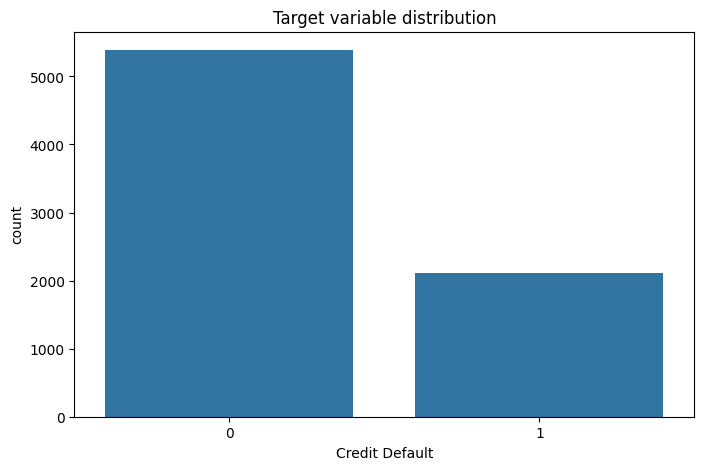

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x=TARGET_NAME, data=train_df)
plt.title('Target variable distribution')
plt.show()

Наблюдается дисбаланс классов: тех, кто погашает кредит вовремя, в 2,5 раза больше, чем тех, у кого просрочка.

##### Оценка признака "Home Ownership" в разрезе целевой переменной

In [ ]:
train_df['Home Ownership'].value_counts()

Home Ownership
Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: count, dtype: int64

Home Mortgage и Have Mortgage - это одно и то же. Переименуем.

In [ ]:
train_df['Home Ownership'] = train_df['Home Ownership'].astype(str).replace('Have Mortgage', 'Home Mortgage')

In [ ]:
train_df['Home Ownership'].value_counts()

Home Ownership
Home Mortgage    3649
Rent             3204
Own Home          647
Name: count, dtype: int64

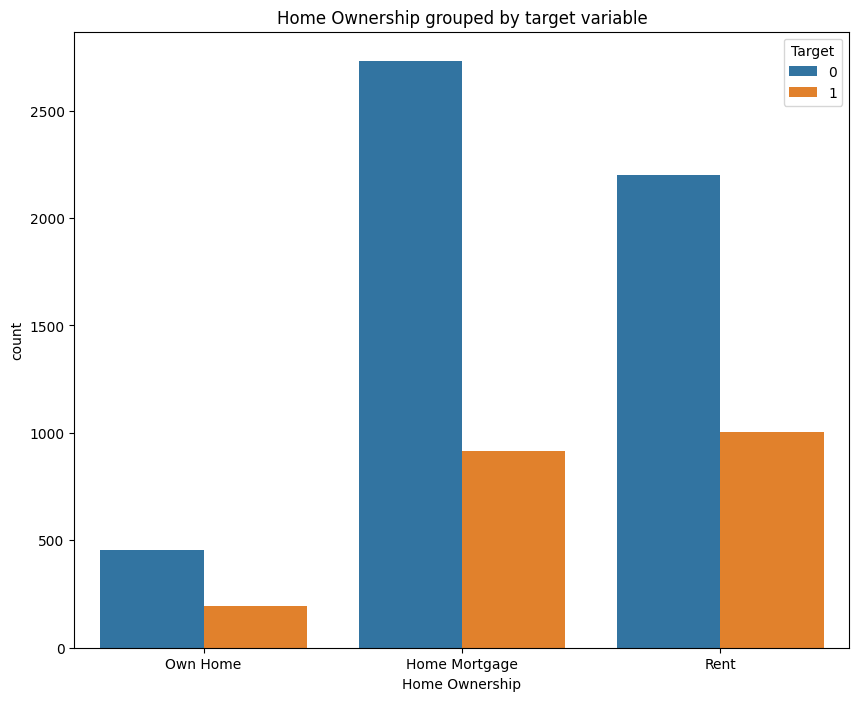

In [ ]:
plt.figure(figsize=(10, 8))
sns.countplot(x='Home Ownership', hue=TARGET_NAME, data=train_df)
plt.title('Home Ownership grouped by target variable')
plt.legend(title='Target', loc='upper right')
plt.show()

**Наблюдение**

Изучив получившийся график, видно, что Home Mortgage и Rent имеют заметно разные доли в разрезе целевой переменной, а вот значения Own Home могут иметь схожие доли как с Home Mortgage, так и с Rent. Если это действительно так, то можно будет, например, объединить их в одну категорию.

**Гипотеза**

* Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы
* Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
* Критерий: Хи-квадрат Пирсона
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Сначала сравним Own Home и Home Mortgage.

In [ ]:
ho_ow_and_target_s = train_df.loc[train_df['Home Ownership'].isin(['Own Home', 'Home Mortgage']), ['Annual Income', 'Home Ownership', 'Credit Default']]

In [ ]:
table = ho_ow_and_target_s.pivot_table(values='Annual Income', index='Home Ownership', columns='Credit Default', aggfunc='count')
table

Credit Default,0,1
Home Ownership,,
Home Mortgage,2218,687
Own Home,369,144


In [ ]:
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

0.031387129861863663

Различия статистически значимы, нельзя объединять Own Home и Home Mortgage в одну категорию. Проверим схожесть Own Home и Rent.

In [ ]:
ho_ow_and_target_s = train_df.loc[train_df['Home Ownership'].isin(['Own Home', 'Rent']), ['Annual Income', 'Home Ownership', 'Credit Default']]

In [ ]:
table = ho_ow_and_target_s.pivot_table(values='Annual Income', index='Home Ownership', columns='Credit Default', aggfunc='count')
table

Credit Default,0,1
Home Ownership,,
Own Home,369,144
Rent,1772,753


In [ ]:
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

0.4278393924491637

P-value получилось значительно больше выбранного уровня значимости, соответственно можно допустить, что категории Own Home и Rent одинаково влияют на целевую переменную и их можно объединить в одну категорию.

In [ ]:
train_df['Home Ownership'] = train_df['Home Ownership'].astype(str).replace('Own Home', 'Rent/Own Home')
train_df['Home Ownership'] = train_df['Home Ownership'].astype(str).replace('Rent', 'Rent/Own Home')

In [ ]:
train_df['Home Ownership'].value_counts()

Home Ownership
Rent/Own Home    3851
Home Mortgage    3649
Name: count, dtype: int64

В итоге, признак Home Ownership был сведён к тому, есть ли у человека ипотека или нет. Сделаем из него признак наличия ипотеки.

In [ ]:
train_df['Home Mortgage'] = train_df['Home Ownership'].map({'Rent/Own Home':'0', 'Home Mortgage':'1'}).astype('uint8')
train_df = train_df.drop('Home Ownership', axis=1)

In [ ]:
train_df.sample(5)

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Home Mortgage
3115,1380198.0,9.0,0,13,18.0,420222,0,16.0,0.0,other,Long Term,328394,281618,30479,723.0,0,0
5441,702430.0,2.0,0,10,8.8,166914,0,NaN,0.0,debt consolidation,Short Term,219824,72219,10478,723.0,0,0
3708,705299.0,1.0,0,22,20.7,1425578,0,NaN,0.0,home improvements,Long Term,108900,155135,19396,742.0,1,1
6456,737333.0,0.0,0,24,42.3,1573066,0,50.0,0.0,debt consolidation,Short Term,125972,55708,2458,733.0,0,1
3808,1123926.0,10.0,0,12,19.4,362362,0,NaN,0.0,debt consolidation,Short Term,47718,193401,13300,738.0,0,1


##### Оценка признака "Purpose" в разрезе целевой переменной

In [ ]:
train_df['Purpose'].value_counts()

Purpose
debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: count, dtype: int64

* take a trip и vacation - это одно и то же, объединить.
* buy house и moving - объединить, так как кредит на moving в принципе и означает buy a house (но не home improvements).
* business loan и small business - можно объединить.

In [ ]:
train_df['Purpose'] = train_df['Purpose'].astype(str).replace('vacation', 'take a trip')
train_df['Purpose'] = train_df['Purpose'].astype(str).replace('moving', 'buy house')
train_df['Purpose'] = train_df['Purpose'].astype(str).replace('small business', 'business loan')

In [ ]:
train_df['Purpose'].value_counts()

Purpose
debt consolidation      5944
other                    665
home improvements        412
business loan            155
buy a car                 96
medical bills             71
take a trip               45
buy house                 45
major purchase            40
wedding                   15
educational expenses      10
renewable energy           2
Name: count, dtype: int64

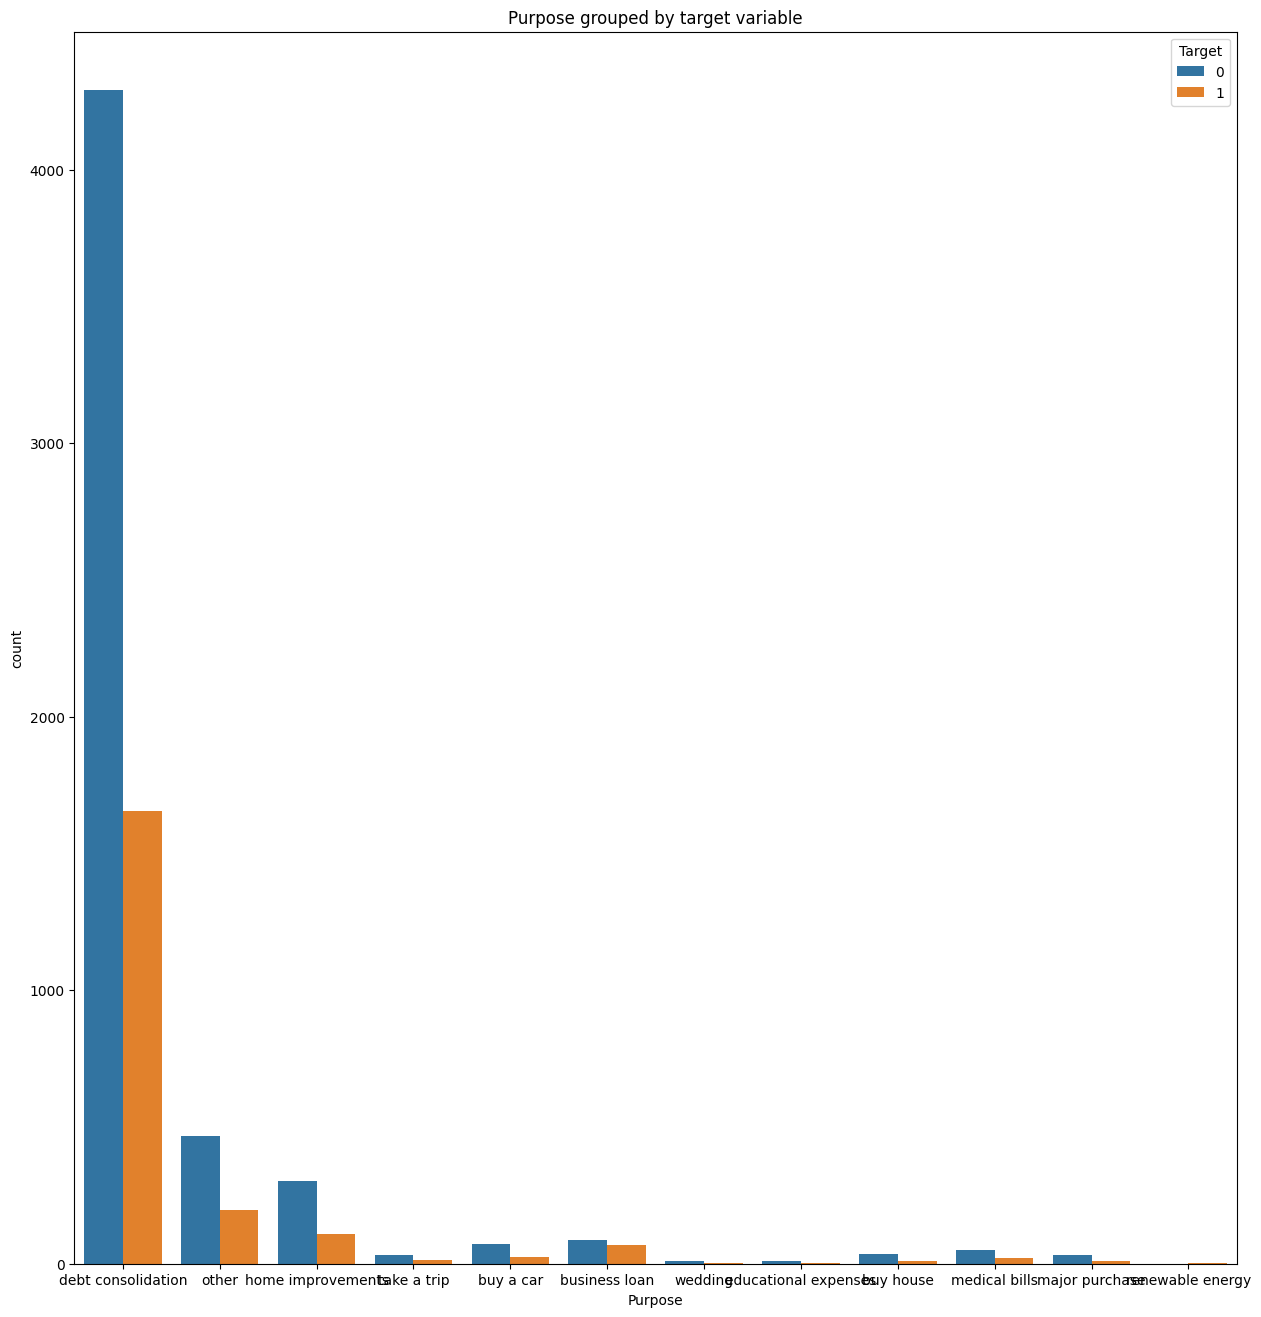

In [ ]:
plt.figure(figsize=(15, 16))

sns.countplot(x="Purpose", hue=TARGET_NAME, data=train_df)
plt.title('Purpose grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

По графику сложно судить о схожести долей. Напишем функцию, которая перебирает все комбинации категорий и находит категории с максимальным p_value.

In [ ]:
# Функция, которая перебирает все комбинации категорий и находит категории с максимальным p_value
def find_highest_p_value(df):
    categories = df['Purpose'].unique()
    max_p_value = 0
    for i in categories:
        for j in categories:
            if i != j:
                purp_and_target_s = train_df.loc[train_df['Purpose'].isin([i, j]), ['Annual Income', 'Purpose', 'Credit Default']]
                table = purp_and_target_s.pivot_table(values='Annual Income', index='Purpose', columns='Credit Default', aggfunc='count')
                chi2, p, dof, expected = chi2_contingency(table, correction=False)
                if p > max_p_value:
                    max_p_value = p
                    categories = [i, j]
    print(max_p_value, categories)

In [ ]:
find_highest_p_value(train_df)

0.9700461349027371 ['debt consolidation', 'major purchase']


P-value почти 100%, соответственно доли этих категорий в разрезе целевой переменной почти одинаковы, и можно допустить, что категории debt consolidation и major purchase одинаково влияют на целевую переменную и их можно объединить в одну категорию.

In [ ]:
train_df['Purpose'] = train_df['Purpose'].astype(str).replace('debt consolidation', 'debt consolidation/major purchase')
train_df['Purpose'] = train_df['Purpose'].astype(str).replace('major purchase', 'debt consolidation/major purchase')

In [ ]:
train_df['Purpose'].value_counts()

Purpose
debt consolidation/major purchase    5984
other                                 665
home improvements                     412
business loan                         155
buy a car                              96
medical bills                          71
take a trip                            45
buy house                              45
wedding                                15
educational expenses                   10
renewable energy                        2
Name: count, dtype: int64

Можно ещё раз поискать высокие p-value

In [ ]:
find_highest_p_value(train_df)

0.8612765252046075 ['debt consolidation/major purchase', 'take a trip']


Добавим категорию take a trip туда же. Назовём категорию просто debt/major purchase.

In [ ]:
train_df['Purpose'] = train_df['Purpose'].astype(str).replace('debt consolidation/major purchase', 'debt/major purchase')
train_df['Purpose'] = train_df['Purpose'].astype(str).replace('take a trip', 'debt/major purchase')

In [ ]:
train_df['Purpose'].value_counts()

Purpose
debt/major purchase     6029
other                    665
home improvements        412
business loan            155
buy a car                 96
medical bills             71
buy house                 45
wedding                   15
educational expenses      10
renewable energy           2
Name: count, dtype: int64

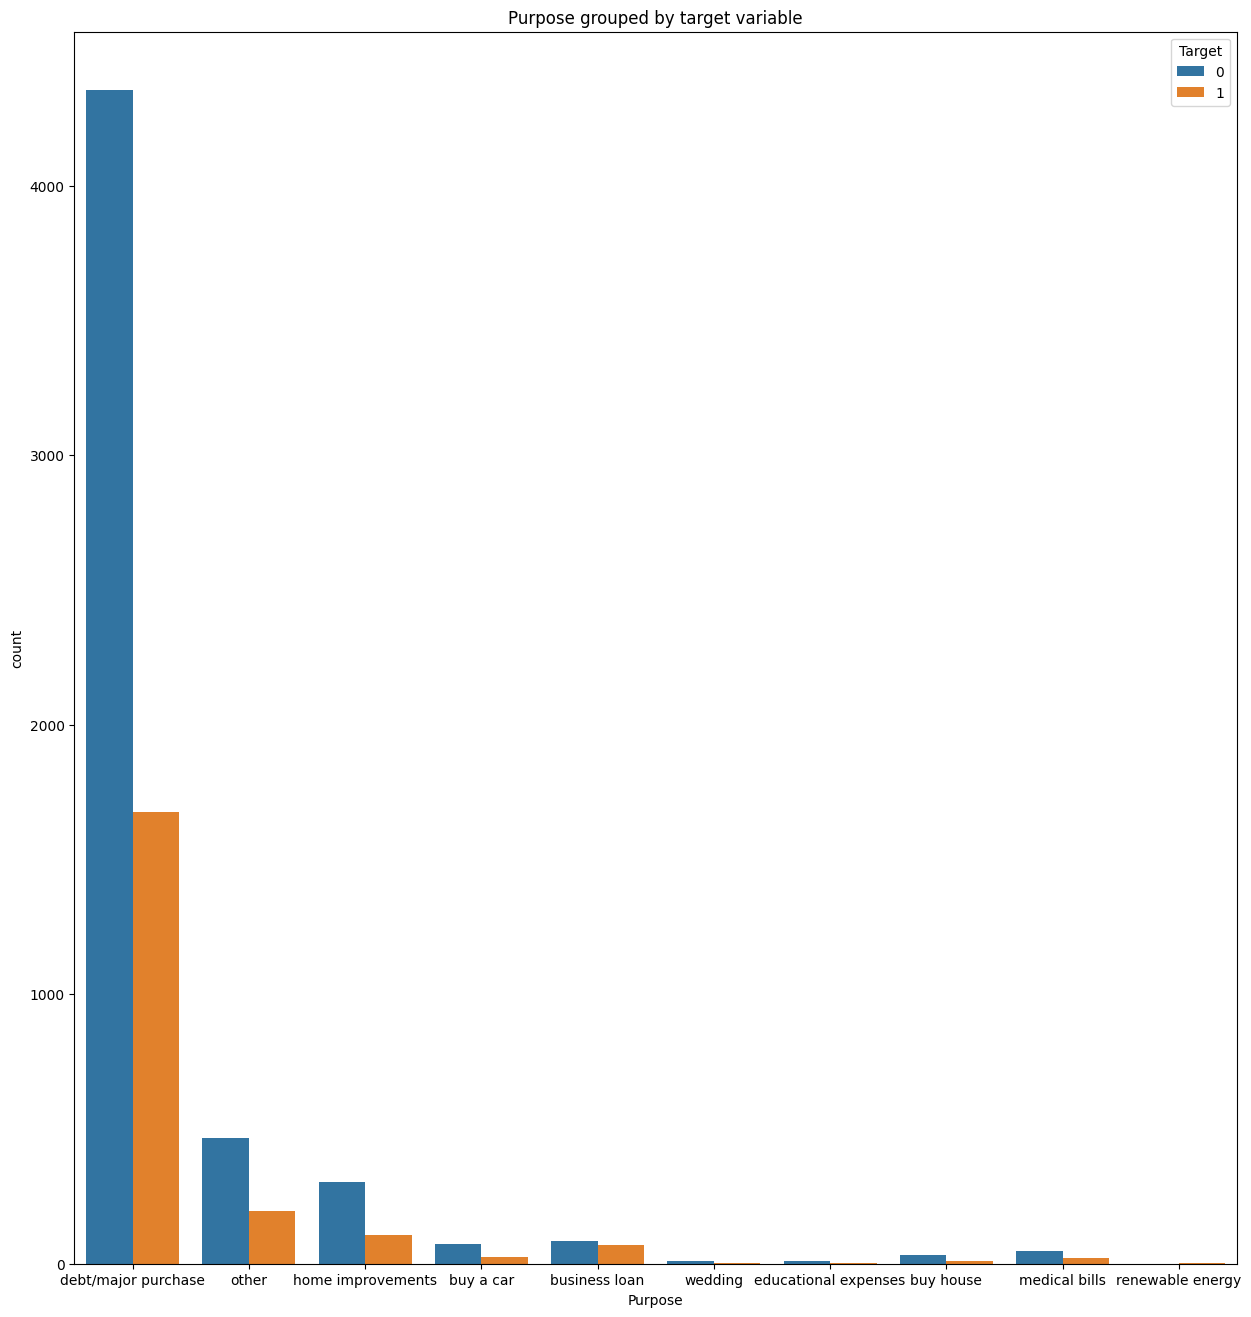

In [ ]:
plt.figure(figsize=(15, 16))

sns.countplot(x="Purpose", hue=TARGET_NAME, data=train_df)
plt.title('Purpose grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

Вообще, можно заметить, что все категории, кроме business loan, имеют примерно одинаковые доли.

Поищем ещё высокий p-value.

In [ ]:
find_highest_p_value(train_df)

0.8602052541583086 ['other', 'buy a car']


Слепим их вместе.

In [ ]:
train_df['Purpose'] = train_df['Purpose'].astype(str).replace('other', 'buy a car/other')
train_df['Purpose'] = train_df['Purpose'].astype(str).replace('buy a car', 'buy a car/other')

In [ ]:
train_df['Purpose'].value_counts()

Purpose
debt/major purchase     6029
buy a car/other          761
home improvements        412
business loan            155
medical bills             71
buy house                 45
wedding                   15
educational expenses      10
renewable energy           2
Name: count, dtype: int64

Продолжим искать и соединять. Остановимся, когда различия будут статистически значимы.

In [ ]:
find_highest_p_value(train_df)

0.8309337095589888 ['buy house', 'wedding']


In [ ]:
train_df['Purpose'] = train_df['Purpose'].astype(str).replace('buy house', 'buy house/wedding')
train_df['Purpose'] = train_df['Purpose'].astype(str).replace('wedding', 'buy house/wedding')

In [ ]:
train_df['Purpose'].value_counts()

Purpose
debt/major purchase     6029
buy a car/other          761
home improvements        412
business loan            155
medical bills             71
buy house/wedding         60
educational expenses      10
renewable energy           2
Name: count, dtype: int64

In [ ]:
find_highest_p_value(train_df)

0.6377573948149979 ['buy a car/other', 'medical bills']


In [ ]:
train_df['Purpose'] = train_df['Purpose'].astype(str).replace('medical bills', 'car/medical/other')
train_df['Purpose'] = train_df['Purpose'].astype(str).replace('buy a car/other', 'car/medical/other')

In [ ]:
train_df['Purpose'].value_counts()

Purpose
debt/major purchase     6029
car/medical/other        832
home improvements        412
business loan            155
buy house/wedding         60
educational expenses      10
renewable energy           2
Name: count, dtype: int64

In [ ]:
find_highest_p_value(train_df)

0.594226352813253 ['buy house/wedding', 'home improvements']


In [ ]:
train_df['Purpose'] = train_df['Purpose'].astype(str).replace('buy house/wedding', 'house/wedding')
train_df['Purpose'] = train_df['Purpose'].astype(str).replace('home improvements', 'house/wedding')

In [ ]:
train_df['Purpose'].value_counts()

Purpose
debt/major purchase     6029
car/medical/other        832
house/wedding            472
business loan            155
educational expenses      10
renewable energy           2
Name: count, dtype: int64

In [ ]:
find_highest_p_value(train_df)

0.4444061056260322 ['house/wedding', 'educational expenses']


In [ ]:
train_df['Purpose'] = train_df['Purpose'].astype(str).replace('educational expenses', 'house/wedding/education')
train_df['Purpose'] = train_df['Purpose'].astype(str).replace('house/wedding', 'house/wedding/education')

In [ ]:
train_df['Purpose'].value_counts()

Purpose
debt/major purchase        6029
car/medical/other           832
house/wedding/education     482
business loan               155
renewable energy              2
Name: count, dtype: int64

In [ ]:
find_highest_p_value(train_df)

0.2739480474075823 ['debt/major purchase', 'car/medical/other']


In [ ]:
train_df['Purpose'] = train_df['Purpose'].astype(str).replace('debt/major purchase', 'debt/purchase/other')
train_df['Purpose'] = train_df['Purpose'].astype(str).replace('car/medical/other', 'debt/purchase/other')

In [ ]:
train_df['Purpose'].value_counts()

Purpose
debt/purchase/other        6861
house/wedding/education     482
business loan               155
renewable energy              2
Name: count, dtype: int64

In [ ]:
find_highest_p_value(train_df)

0.028774584081986535 ['debt/purchase/other', 'house/wedding/education']


С этого момента объединять категории уже нельзя, так как различия статистически значимы.

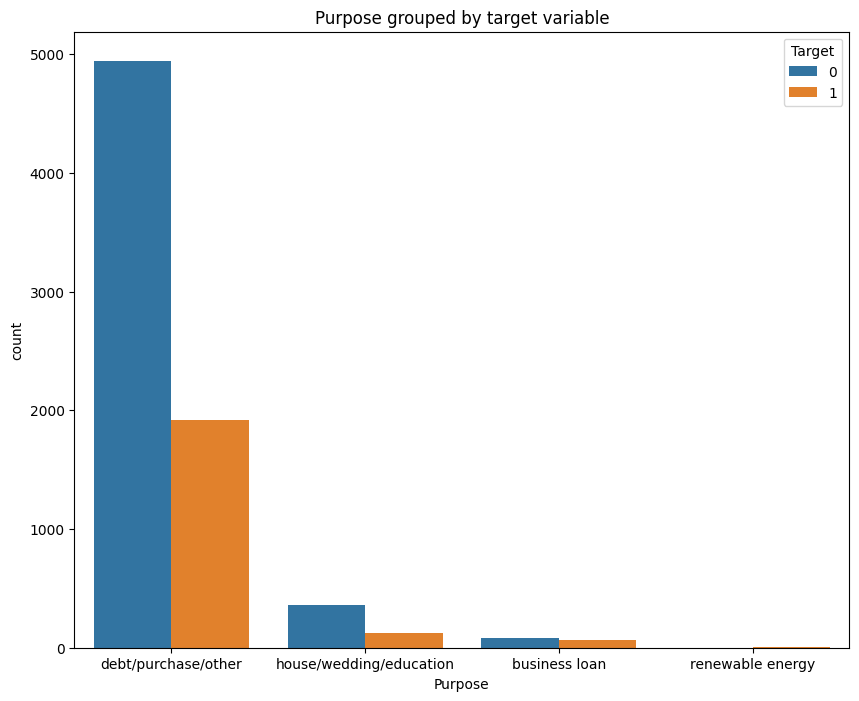

In [ ]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Purpose", hue=TARGET_NAME, data=train_df)
plt.title('Purpose grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

Renewable energy можно поместить в business loan, так как там всего 2 наблюдения

#### Обзор количественных признаков

In [ ]:
pd.options.display.float_format = '{:.1f}'.format
train_df.describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5943.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,3419.0,7486.0,7500.0,7500.0,7500.0,5943.0,7500.0
mean,1366391.7,5.6,0.0,11.1,18.3,945153.7,0.2,34.7,0.1,11873177.4,289833.2,18314.5,1151.1,0.3
std,845339.2,3.7,0.3,4.9,7.0,16026216.7,0.5,21.7,0.3,31926123.0,317871.4,11926.8,1604.5,0.4
min,164597.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,11242.0,0.0,0.0,585.0,0.0
25%,844341.0,2.0,0.0,8.0,13.5,279229.5,0.0,16.0,0.0,180169.0,114256.5,10067.5,711.0,0.0
50%,1168386.0,6.0,0.0,10.0,17.0,478159.0,0.0,32.0,0.0,309573.0,209323.0,16076.5,731.0,0.0
75%,1640137.0,10.0,0.0,14.0,21.8,793501.5,0.0,50.0,0.0,519882.0,360406.2,23818.0,743.0,1.0
max,10149344.0,10.0,7.0,43.0,57.7,1304726170.0,7.0,118.0,4.0,99999999.0,6506797.0,136679.0,7510.0,1.0


* Annual Income: я думаю, что здесь нет выбросов, несмотря на то, что максимальное значение очень большое. Там много таких больших значений, и все разные. Если заменять эти большие значения, то это плохо влияет на корреляцию с целевой переменной.
* Maximum Open Credit: максимальное значение слишком высокое. 0 - максимальная сумма кредита не может быть, потому что Years of Credit History > 0, то есть у человека есть кредитная история, и значит он брал кредит.
* Current Loan Amount: 99999999 - выбросы.
* Credit Score: больше 1000 не бывает.
* Current Credit Balance: нужно будет проверить максимальные значения.

In [ ]:
pd.options.display.float_format = None

#### Обзор номинативных признаков

In [ ]:
for cat_col in train_df.select_dtypes(include='category').columns:
    print(str(cat_col) + '\n\n' + str(train_df[cat_col].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Ownership
Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: count, dtype: int64
****************************************************************************************************

Purpose

Purpose
debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: count, dtype: int64
****************************************************************************************************

Term

Term
Short Term    5556
Long Term     1944
Name: count, dtype: int64
**************************************************************************************************

* Home Mortgage и Have Mortgage - это одно и то же, Нужно объединить
* take a trip и vacation - это одно и то же, объединить
* buy house и moving - можно объединить, так как кредит на moving в принципе и означает buy a house (но не home improvements).
* business loan и small business - тоже думаю, что можно объединить
* Term перевести в бинарный признак

## 1.2. Обработка выбросов

In [ ]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.57 MB
Decreased by 41.9%


In [ ]:
pd.options.display.float_format = '{:.1f}'.format
train_df.describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5943.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,3419.0,7486.0,7500.0,7500.0,7500.0,5943.0,7500.0
mean,1366391.7,5.6,0.0,11.1,18.3,945153.7,0.2,34.7,0.1,11873177.4,289833.2,18314.5,1151.1,0.3
std,845339.2,3.7,0.3,4.9,7.0,16026216.7,0.5,21.7,0.3,31926123.0,317871.4,11926.8,1604.5,0.4
min,164597.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,11242.0,0.0,0.0,585.0,0.0
25%,844341.0,2.0,0.0,8.0,13.5,279229.5,0.0,16.0,0.0,180169.0,114256.5,10067.5,711.0,0.0
50%,1168386.0,6.0,0.0,10.0,17.0,478159.0,0.0,32.0,0.0,309573.0,209323.0,16076.5,731.0,0.0
75%,1640137.0,10.0,0.0,14.0,21.8,793501.5,0.0,50.0,0.0,519882.0,360406.2,23818.0,743.0,1.0
max,10149344.0,10.0,7.0,43.0,57.7,1304726170.0,7.0,118.0,4.0,99999999.0,6506797.0,136679.0,7510.0,1.0


* **Annual Income**: исследовать максимальные значения
* **Maximum Open Credit**: максимальное значение слишком высокое. 0 - максимальная сумма кредита не может быть, потому что Years of Credit History > 0, то есть у человека есть кредитная история, и значит он брал кредит.
* **Current Loan Amount**: 99999999 - выбросы.
* **Current Credit Balance**: нужно проверить максимальные значения.
* **Monthly Debt**: не может быть 0, так как минимальное значение Current Loan Amount != 0, значит у всех наблюдений есть невыплаченные кредиты, и следовательно, ежемесячный долг.
* **Credit Score**: больше 800 не бывает.

### Annual Income

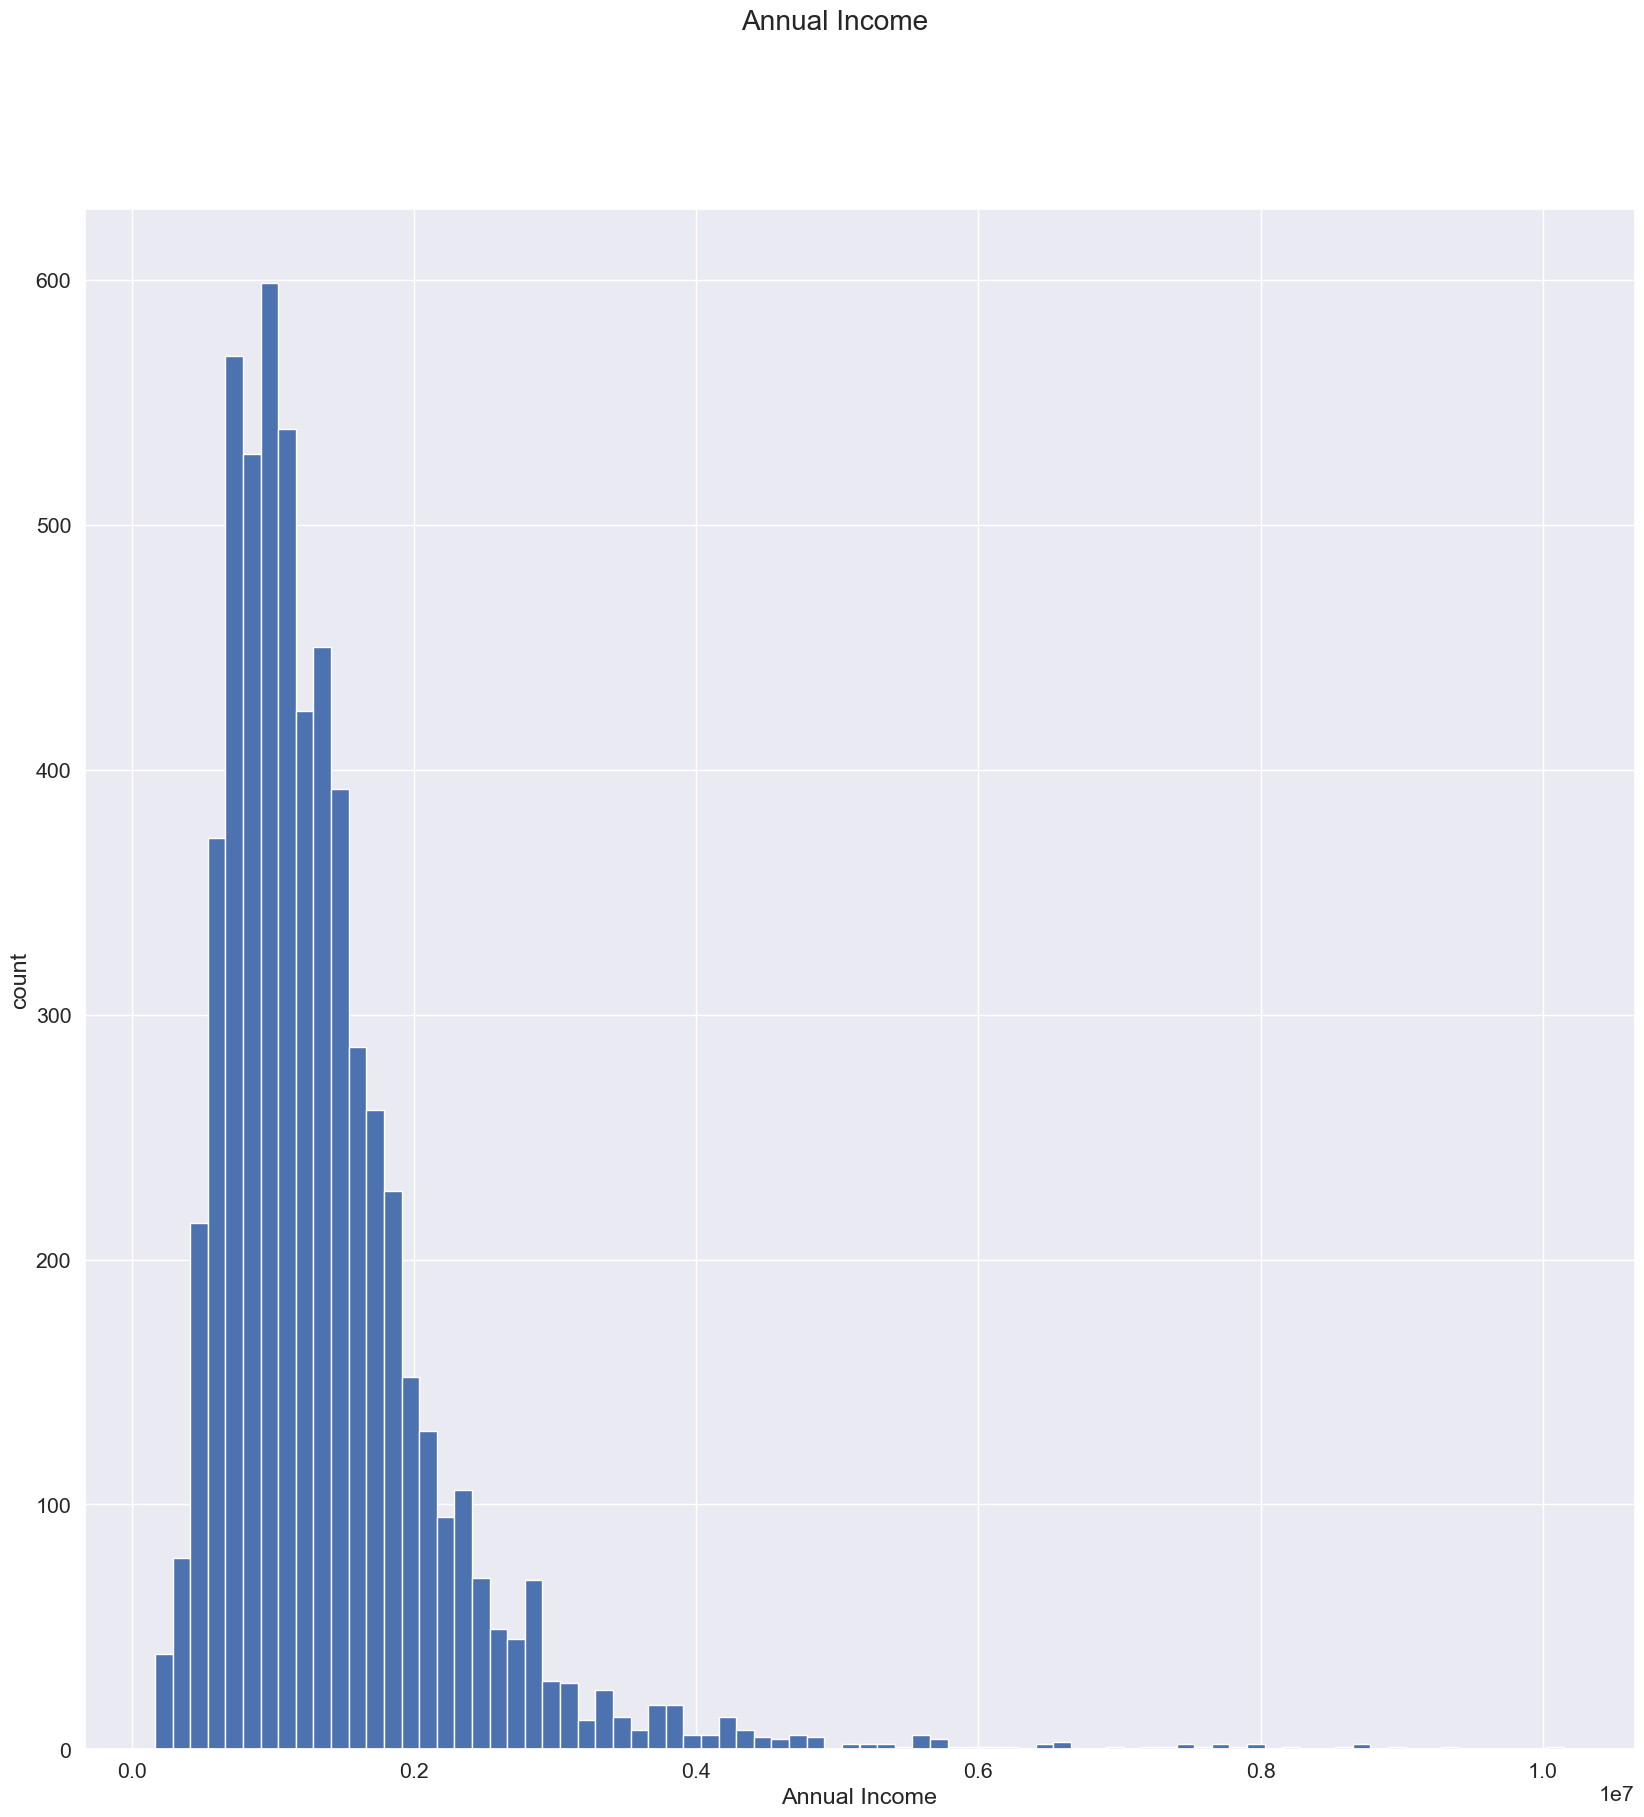

In [ ]:
plt.figure(figsize = (20, 20))

train_df['Annual Income'].hist(density=False, bins=80)
plt.ylabel('count')
plt.xlabel('Annual Income')

plt.suptitle('Annual Income')
plt.show()

In [ ]:
train_df.loc[train_df['Annual Income'] > 8000000, 'Annual Income'] = train_df['Annual Income'] \
                                                                    [train_df['Annual Income'] < 8000000].median()

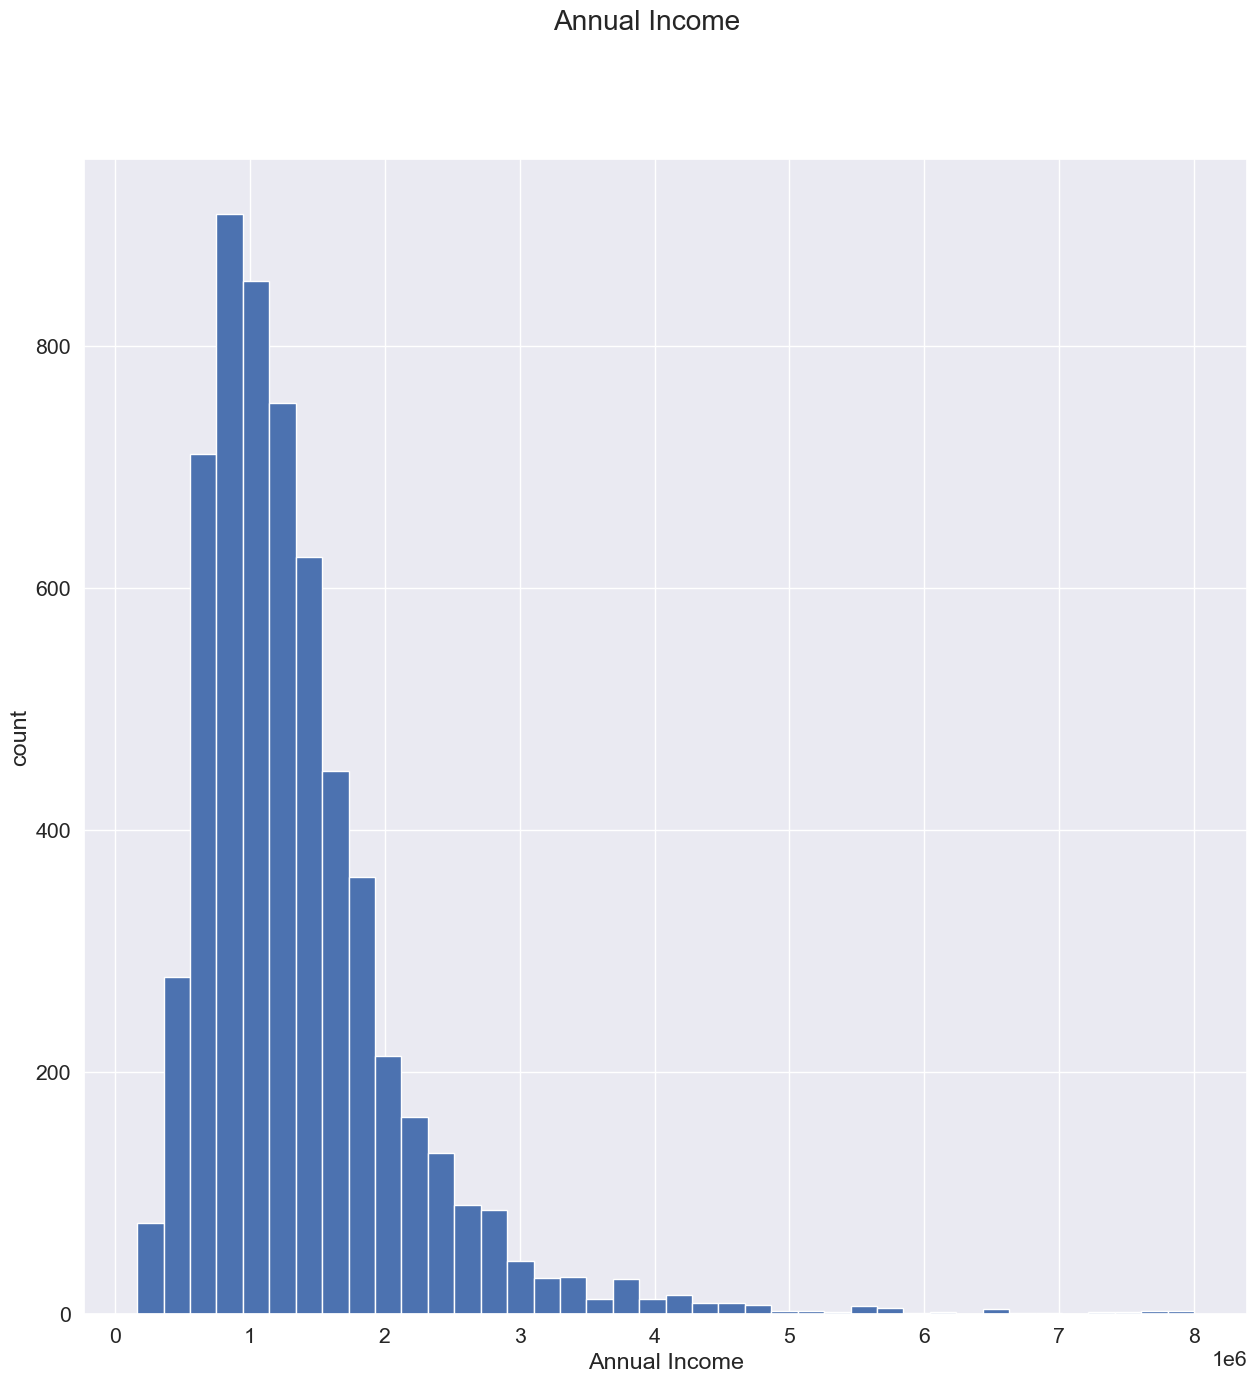

In [ ]:
plt.figure(figsize = (15, 15))

train_df['Annual Income'].hist(density=False, bins=40)
plt.ylabel('count')
plt.xlabel('Annual Income')

plt.suptitle('Annual Income')
plt.show()

In [ ]:
train_df.loc[train_df['Annual Income'] > 6000000, 'Annual Income'] = train_df['Annual Income'] \
                                                                    [train_df['Annual Income'] < 6000000].median()

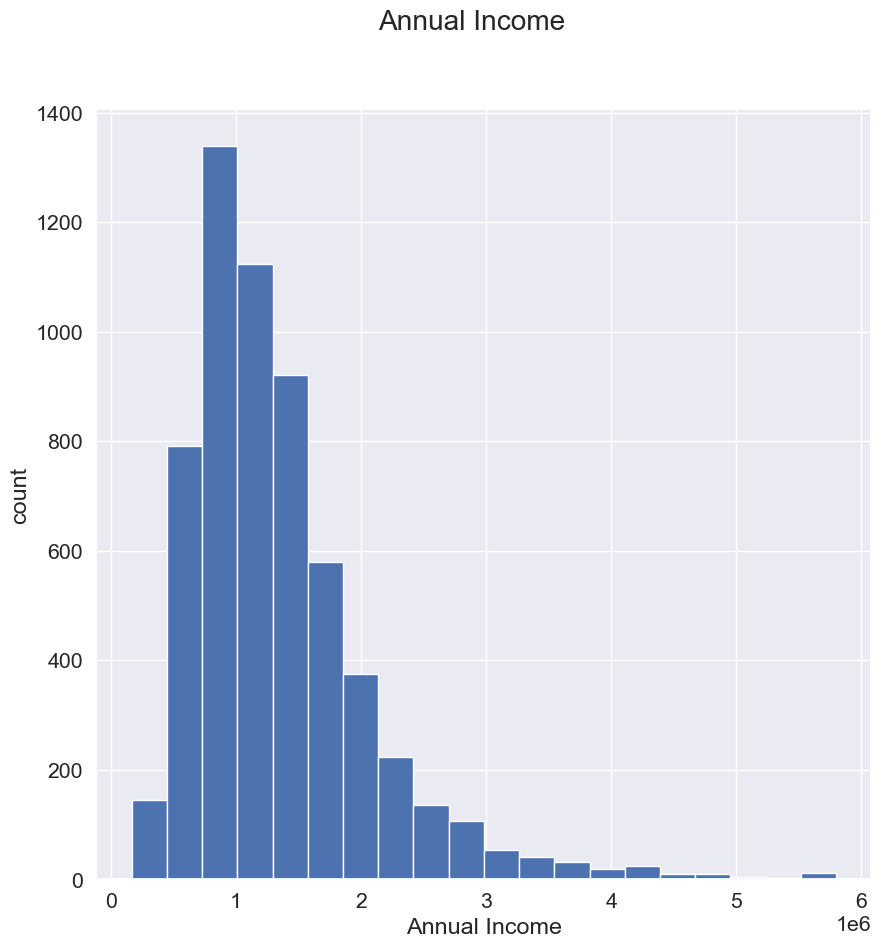

In [ ]:
plt.figure(figsize = (10, 10))

train_df['Annual Income'].hist(density=False, bins=20)
plt.ylabel('count')
plt.xlabel('Annual Income')

plt.suptitle('Annual Income')
plt.show()

In [ ]:
train_df.loc[train_df['Annual Income'] > 5500000, 'Annual Income'] = train_df['Annual Income'] \
                                                                    [train_df['Annual Income'] < 5500000].median()

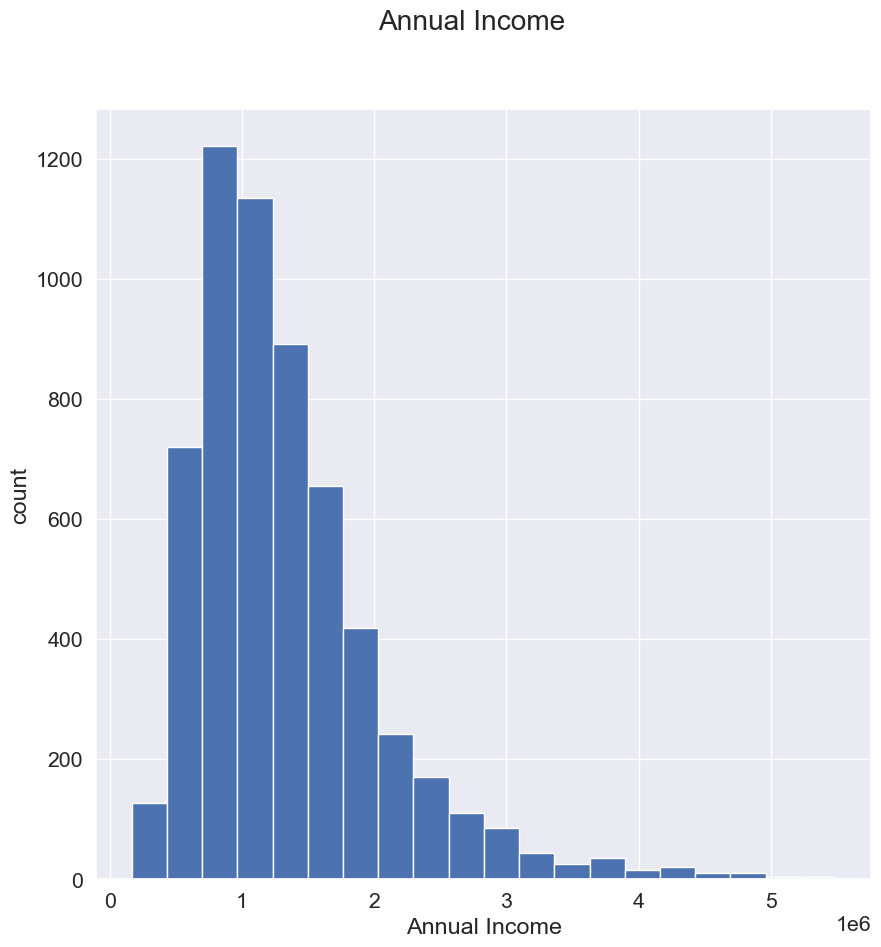

In [ ]:
plt.figure(figsize = (10, 10))

train_df['Annual Income'].hist(density=False, bins=20)
plt.ylabel('count')
plt.xlabel('Annual Income')

plt.suptitle('Annual Income')
plt.show()

Теперь выглядит более-менее нормально

### Maximum Open Credit

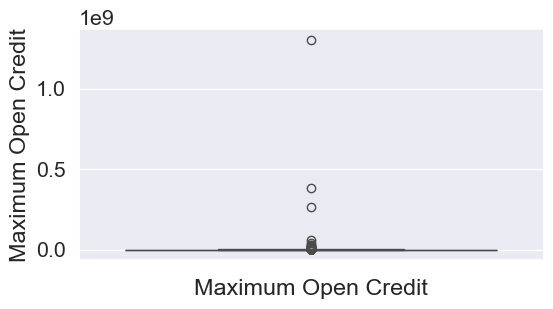

In [ ]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['Maximum Open Credit'], whis=1.5)

plt.xlabel('Maximum Open Credit')
plt.show()

In [ ]:
train_df.loc[train_df['Maximum Open Credit'] > 100000000, 'Maximum Open Credit'] = train_df['Maximum Open Credit'] \
                                        [(train_df['Maximum Open Credit'] > 0) & (train_df['Maximum Open Credit'] < 3000000)].median()
# 3000000 - я уже посмотрела, выбросы начинаются после этого числа

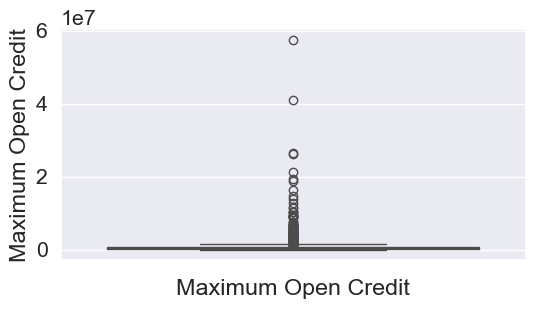

In [ ]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['Maximum Open Credit'], whis=1.5)

plt.xlabel('Maximum Open Credit')
plt.show()

In [ ]:
train_df.loc[train_df['Maximum Open Credit'] > 15000000, 'Maximum Open Credit'] = train_df['Maximum Open Credit'] \
                                        [(train_df['Maximum Open Credit'] > 0) & (train_df['Maximum Open Credit'] < 3000000)].median()

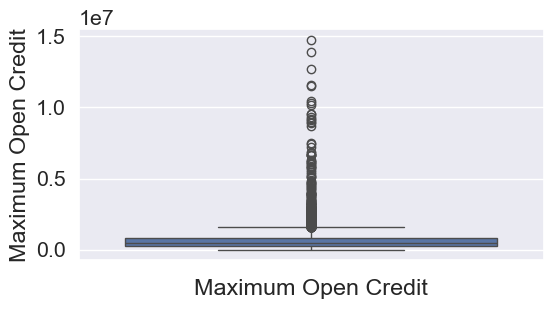

In [ ]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['Maximum Open Credit'], whis=1.5)

plt.xlabel('Maximum Open Credit')
plt.show()

In [ ]:
train_df.loc[train_df['Maximum Open Credit'] > 8000000, 'Maximum Open Credit'] = train_df['Maximum Open Credit'] \
                                        [(train_df['Maximum Open Credit'] > 0) & (train_df['Maximum Open Credit'] < 3000000)].median()

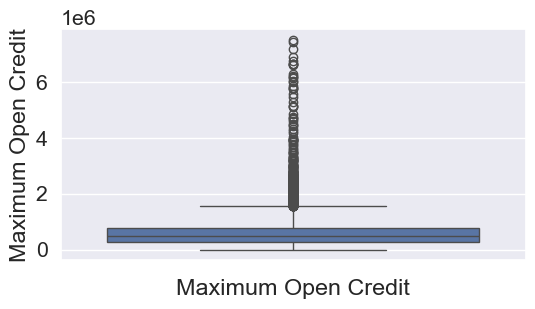

In [ ]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['Maximum Open Credit'], whis=1.5)

plt.xlabel('Maximum Open Credit')
plt.show()

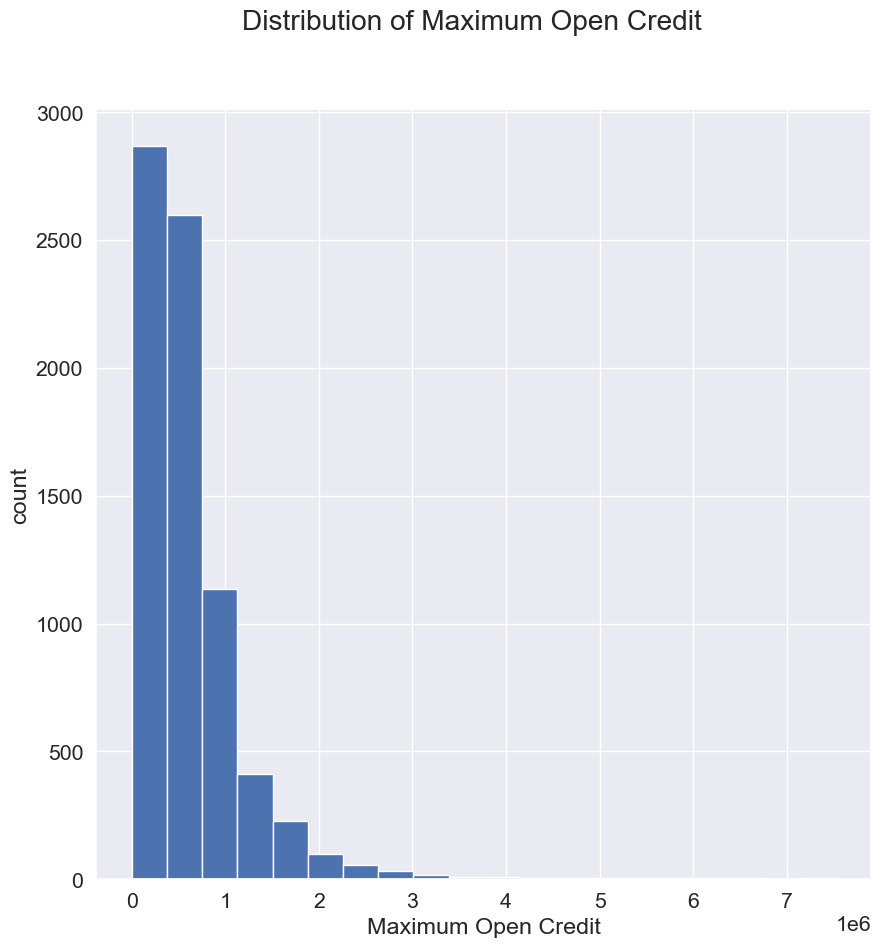

In [ ]:
plt.figure(figsize = (10, 10))

train_df['Maximum Open Credit'].hist(density=False, bins=20)
plt.ylabel('count')
plt.xlabel('Maximum Open Credit')

plt.suptitle('Distribution of Maximum Open Credit')
plt.show()

In [ ]:
train_df.loc[train_df['Maximum Open Credit'] > 3500000, 'Maximum Open Credit'] = train_df['Maximum Open Credit'] \
                                        [(train_df['Maximum Open Credit'] > 0) & (train_df['Maximum Open Credit'] < 3000000)].median()

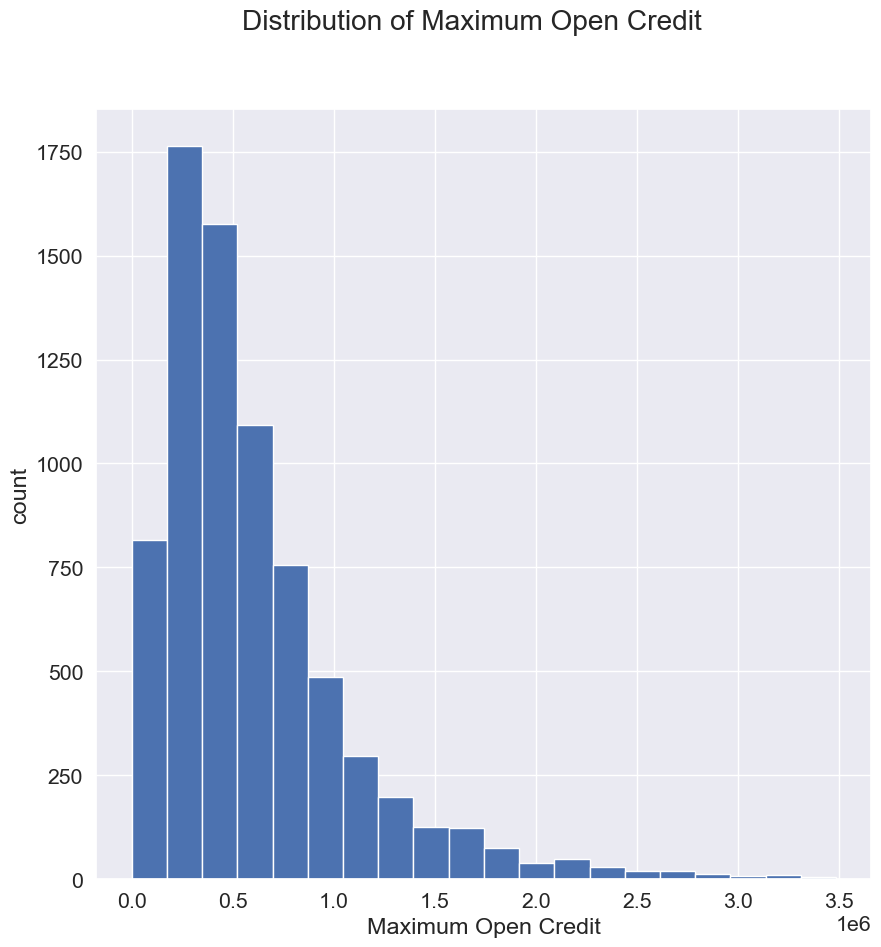

In [ ]:
plt.figure(figsize = (10, 10))

train_df['Maximum Open Credit'].hist(density=False, bins=20)
plt.ylabel('count')
plt.xlabel('Maximum Open Credit')

plt.suptitle('Distribution of Maximum Open Credit')
plt.show()

In [ ]:
train_df.loc[train_df['Maximum Open Credit'] > 3000000, 'Maximum Open Credit'] = train_df['Maximum Open Credit'] \
                                        [(train_df['Maximum Open Credit'] > 0) & (train_df['Maximum Open Credit'] < 3000000)].median()

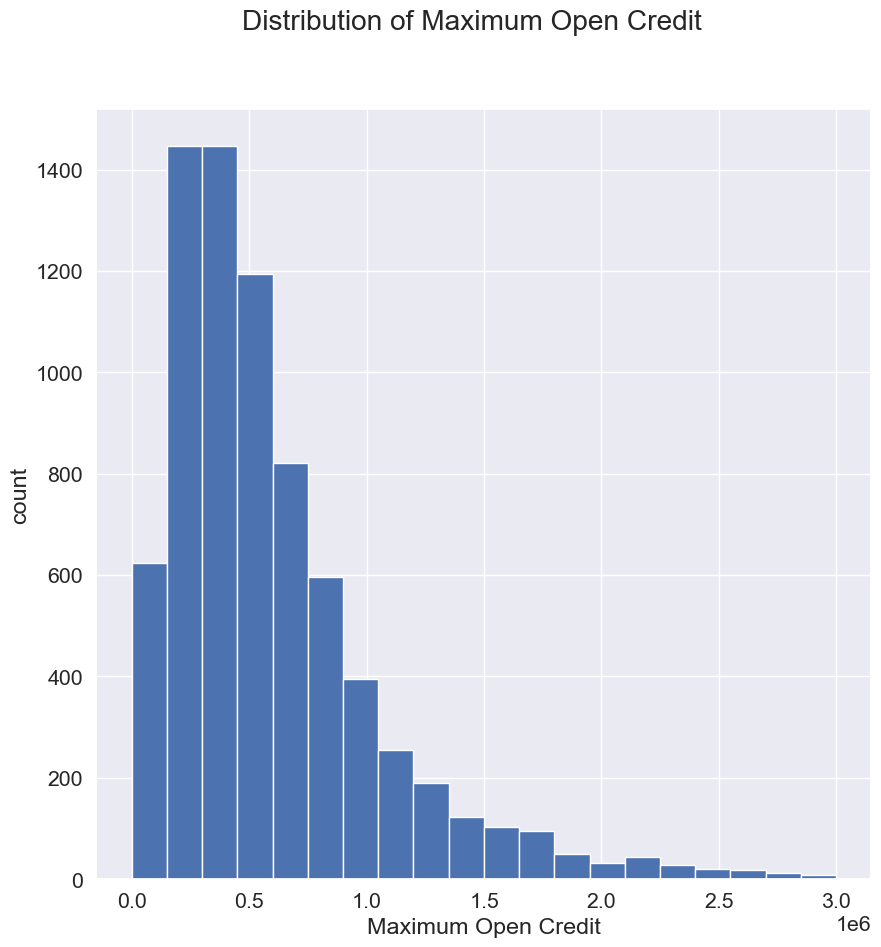

In [ ]:
plt.figure(figsize = (10, 10))

train_df['Maximum Open Credit'].hist(density=False, bins=20)
plt.ylabel('count')
plt.xlabel('Maximum Open Credit')

plt.suptitle('Distribution of Maximum Open Credit')
plt.show()

Теперь выглядит более-менее нормально

In [ ]:
train_df['Maximum Open Credit'].value_counts()

Maximum Open Credit
476476    100
0          65
319110      5
334796      3
294030      3
         ... 
543620      1
383108      1
407506      1
354640      1
480832      1
Name: count, Length: 6865, dtype: int64

In [ ]:
train_df.loc[train_df['Maximum Open Credit'] == 0, 'Maximum Open Credit'] = train_df['Maximum Open Credit'] \
                                        [(train_df['Maximum Open Credit'] > 0) & (train_df['Maximum Open Credit'] < 3000000)].median()

In [ ]:
train_df['Maximum Open Credit'].value_counts()

Maximum Open Credit
476476    165
319110      5
443630      3
357874      3
246224      3
         ... 
383108      1
407506      1
354640      1
932778      1
480832      1
Name: count, Length: 6864, dtype: int64

### Current Loan Amount

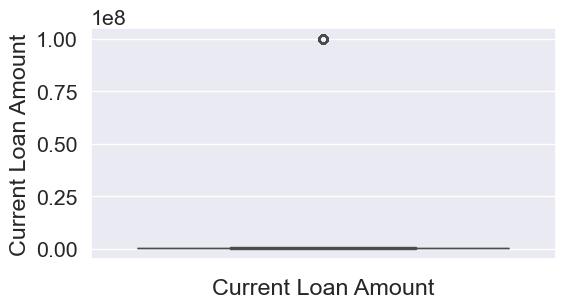

In [ ]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['Current Loan Amount'], whis=1.5)

plt.xlabel('Current Loan Amount')
plt.show()

In [ ]:
(train_df['Current Loan Amount'] > 25000000).sum()

870

In [ ]:
train_df.loc[train_df['Current Loan Amount'] > 25000000, 'Current Loan Amount'] = train_df['Current Loan Amount'] \
                                                                                [train_df['Current Loan Amount'] < 25000000].median()

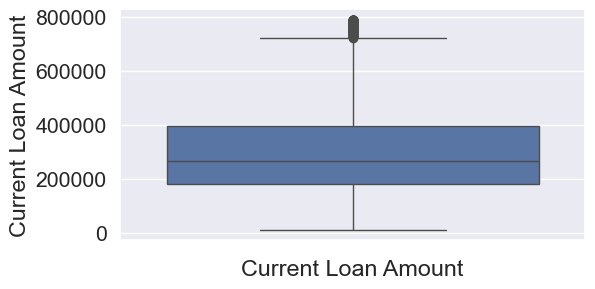

In [ ]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['Current Loan Amount'], whis=1.5)

plt.xlabel('Current Loan Amount')
plt.show()

### Current Credit Balance
Сумма задолженности по кредитной карте. 0 может быть (человек не пользуется кредиткой, следовательно, кредитная задолженность = 0).
С максимальними значениями непонятно, что считать выбросами.

In [ ]:
train_df['Current Credit Balance'].value_counts()

Current Credit Balance
0         53
191710     5
106818     4
83638      4
136401     4
          ..
445360     1
243371     1
25688      1
62054      1
288192     1
Name: count, Length: 6592, dtype: int64

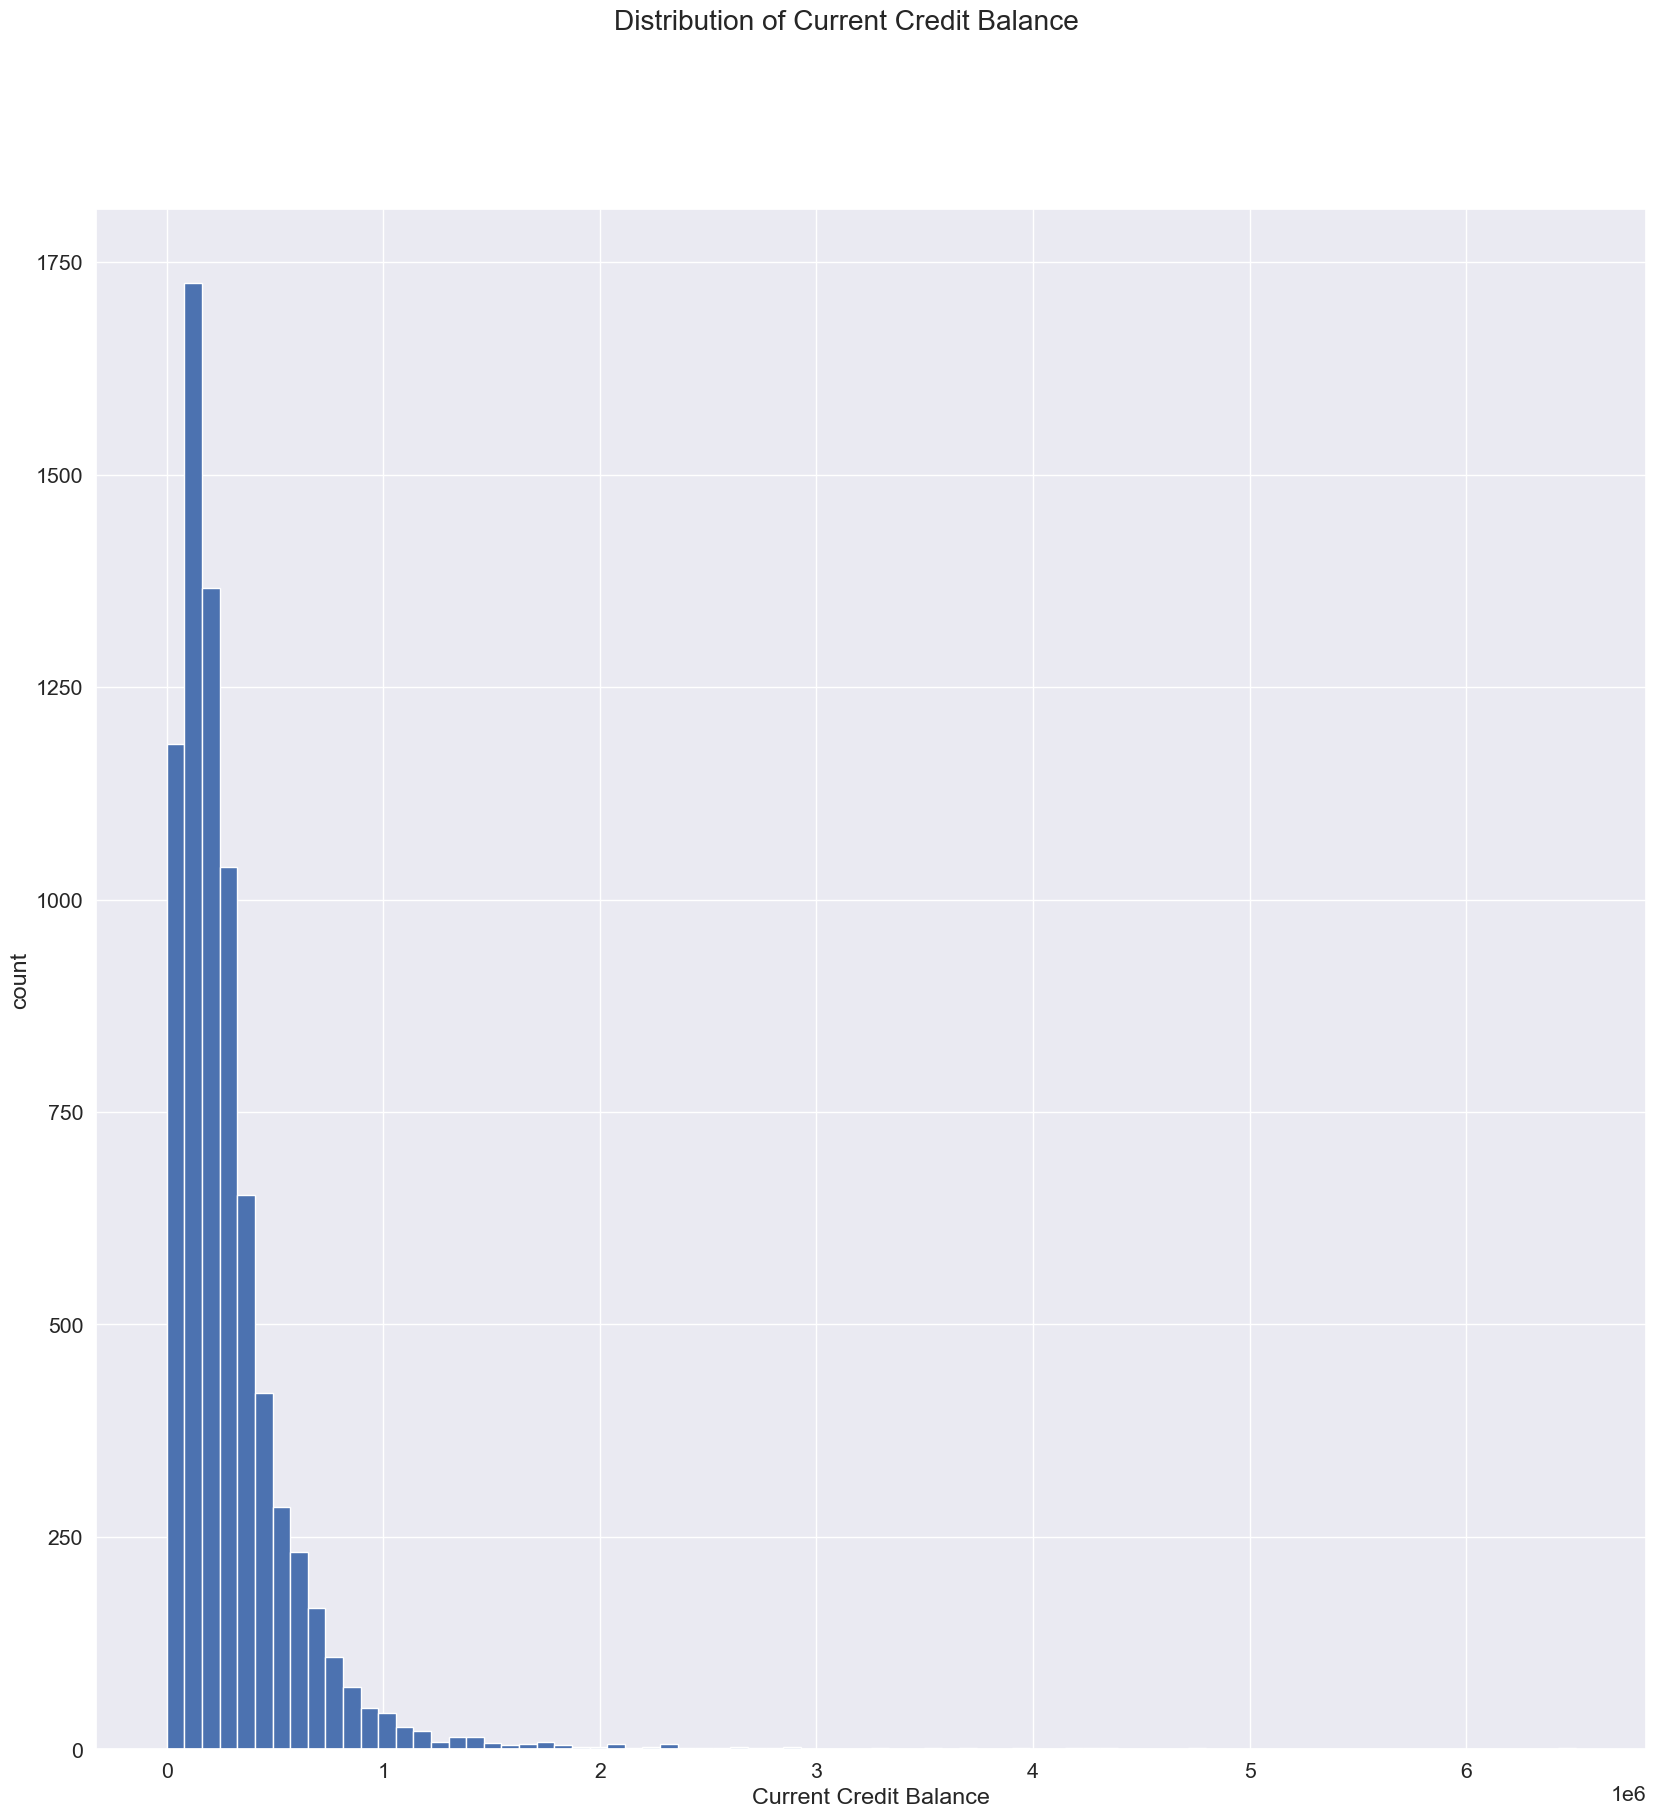

In [ ]:
plt.figure(figsize = (20, 20))

train_df['Current Credit Balance'].hist(density=False, bins=80)
plt.ylabel('count')
plt.xlabel('Current Credit Balance')

plt.suptitle('Distribution of Current Credit Balance')
plt.show()

In [ ]:
train_df.loc[train_df['Current Credit Balance'] > 3000000, 'Current Credit Balance'] = train_df['Current Credit Balance'] \
                                                                                [train_df['Current Credit Balance'] < 1300000].median()

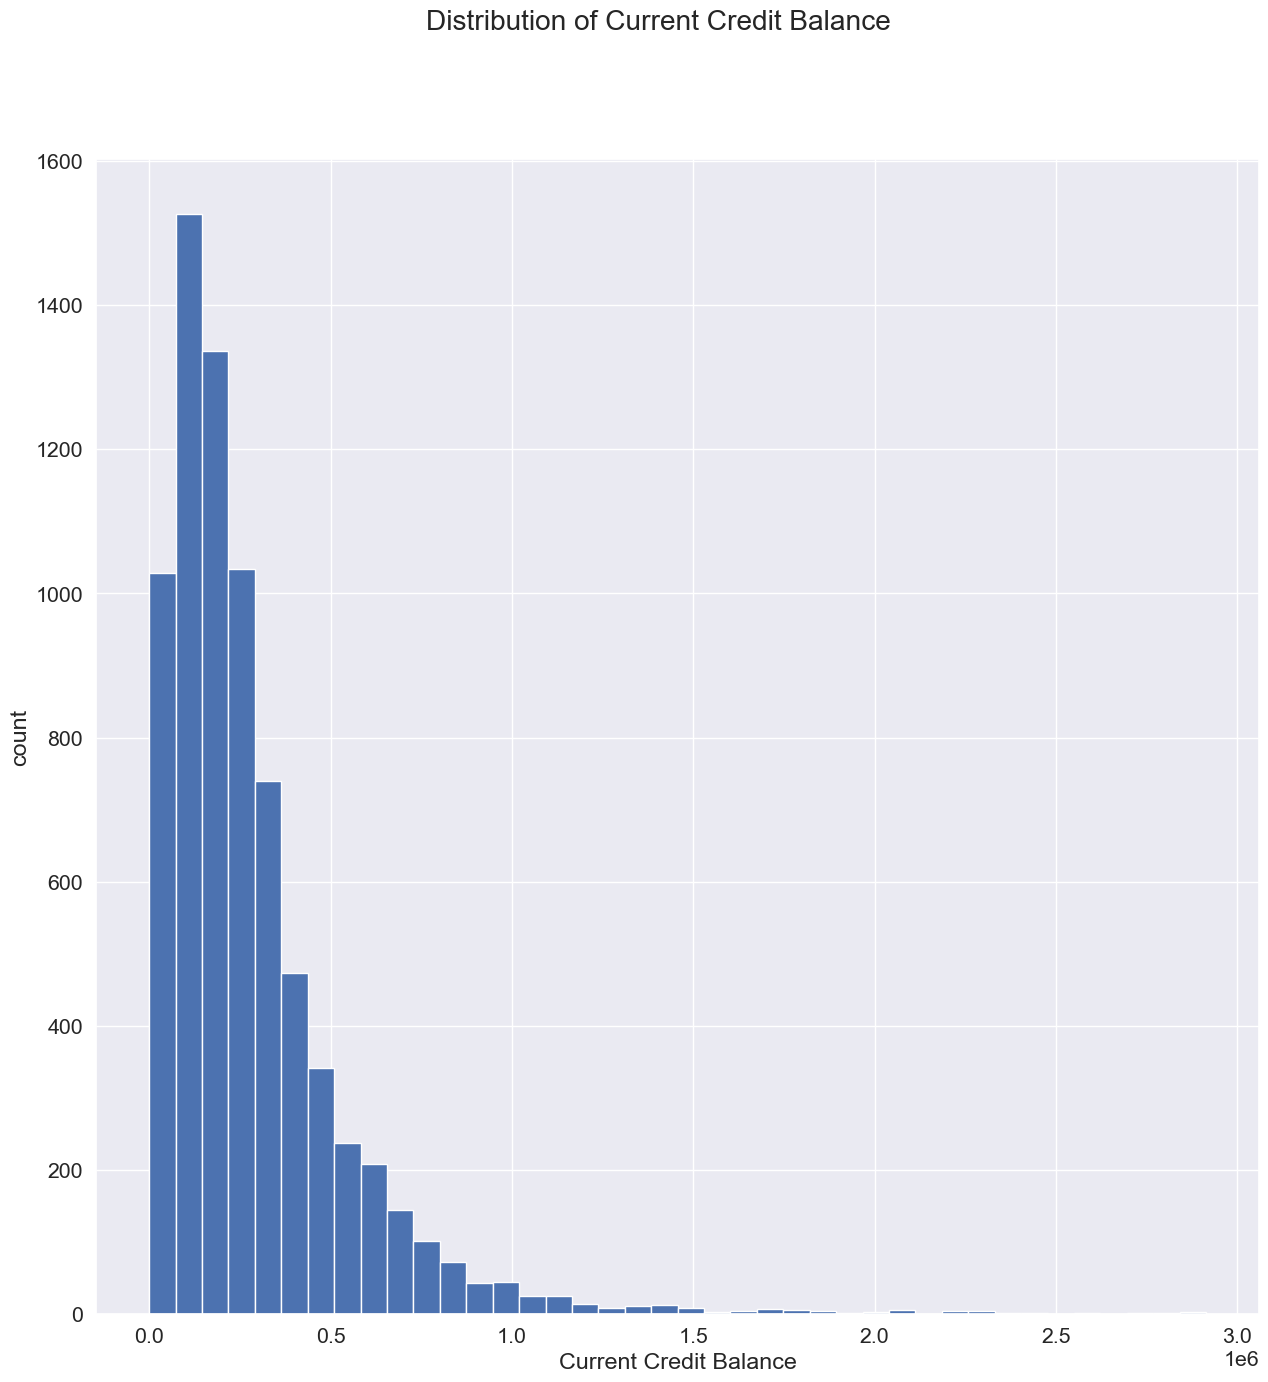

In [ ]:
plt.figure(figsize = (15, 15))

train_df['Current Credit Balance'].hist(density=False, bins=40)
plt.ylabel('count')
plt.xlabel('Current Credit Balance')

plt.suptitle('Distribution of Current Credit Balance')
plt.show()

In [ ]:
train_df.loc[train_df['Current Credit Balance'] > 2000000, 'Current Credit Balance'] = train_df['Current Credit Balance'] \
                                                                                [train_df['Current Credit Balance'] < 1300000].median()

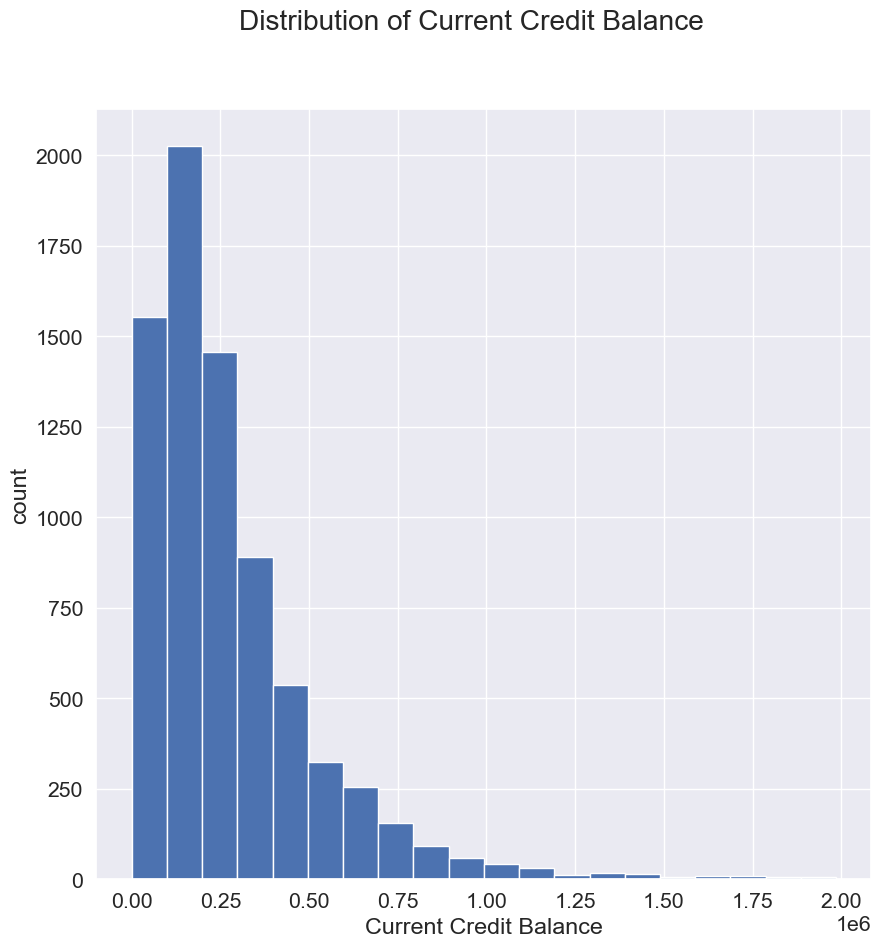

In [ ]:
plt.figure(figsize = (10, 10))

train_df['Current Credit Balance'].hist(density=False, bins=20)
plt.ylabel('count')
plt.xlabel('Current Credit Balance')

plt.suptitle('Distribution of Current Credit Balance')
plt.show()

In [ ]:
train_df.loc[train_df['Current Credit Balance'] > 1500000, 'Current Credit Balance'] = train_df['Current Credit Balance'] \
                                                                                [train_df['Current Credit Balance'] < 1300000].median()

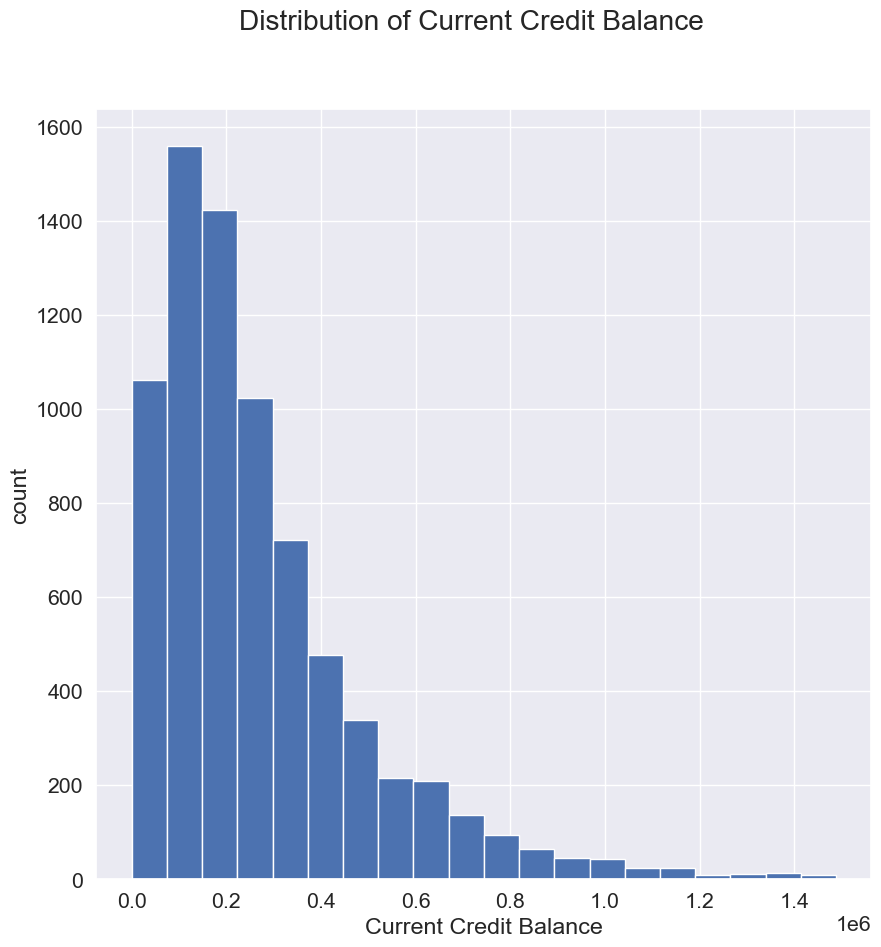

In [ ]:
plt.figure(figsize = (10, 10))

train_df['Current Credit Balance'].hist(density=False, bins=20)
plt.ylabel('count')
plt.xlabel('Current Credit Balance')

plt.suptitle('Distribution of Current Credit Balance')
plt.show()

In [ ]:
train_df.loc[train_df['Current Credit Balance'] > 1300000, 'Current Credit Balance'] = train_df['Current Credit Balance'] \
                                                                                [train_df['Current Credit Balance'] < 1300000].median()

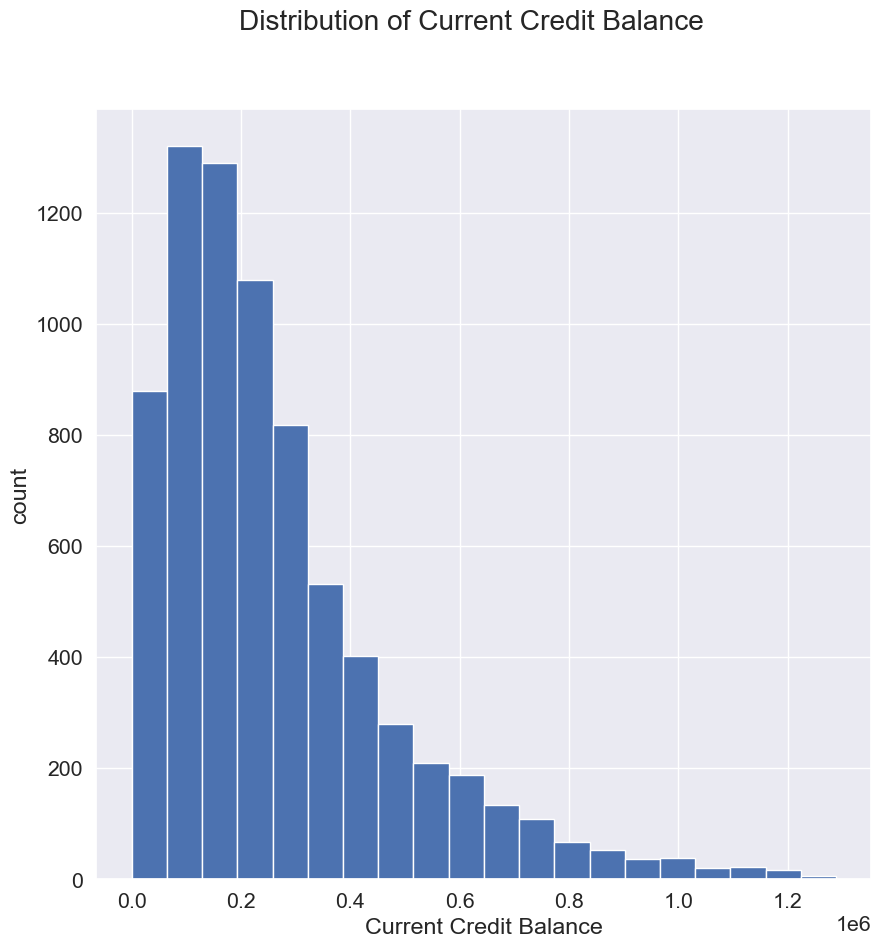

In [ ]:
plt.figure(figsize = (10, 10))

train_df['Current Credit Balance'].hist(density=False, bins=20)
plt.ylabel('count')
plt.xlabel('Current Credit Balance')

plt.suptitle('Distribution of Current Credit Balance')
plt.show()

Теперь более-менее нормально выглядит.

### Monthly Debt

In [ ]:
train_df['Monthly Debt'].value_counts()

Monthly Debt
0        6
19222    4
19667    4
12986    3
13356    3
        ..
33217    1
8203     1
15150    1
1992     1
9061     1
Name: count, Length: 6716, dtype: int64

In [ ]:
train_df.loc[train_df['Monthly Debt'] == 0, 'Monthly Debt'] = train_df['Monthly Debt'] \
                                                              [train_df['Monthly Debt'] > 0].median()

In [ ]:
train_df['Monthly Debt'].sort_values()

8          17.0
4256       21.0
4486       42.0
5002       57.0
5867      236.0
         ...   
6253    96177.0
6946   100091.0
2535   104036.0
1615   110311.0
4745   136679.0
Name: Monthly Debt, Length: 7500, dtype: float64

### Credit Score

In [ ]:
train_df[train_df['Credit Score'] > 800]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
69,Home Mortgage,1408527.0,2.0,0,12,17.5,700062,0,21.0,0.0,other,Long Term,525998,174135,9320,6470.0,1
87,Home Mortgage,1533566.0,7.0,0,11,14.8,715462,0,19.0,0.0,debt consolidation,Short Term,210826,285475,18147,7440.0,1
94,Rent,1049294.0,3.0,0,5,6.1,249810,0,NaN,0.0,business loan,Short Term,337502,119529,15215,7010.0,1
96,Rent,757568.0,5.0,0,13,11.4,383548,0,NaN,0.0,debt consolidation,Short Term,210518,276583,11553,7320.0,1
116,Home Mortgage,1039984.0,0.0,0,10,23.8,147950,0,63.0,0.0,debt consolidation,Short Term,224246,95456,13780,7390.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7422,Rent,694868.0,1.0,0,4,7.8,143066,0,NaN,0.0,debt consolidation,Long Term,244178,122075,4268,6690.0,1
7433,Rent,2011758.0,0.5,0,4,14.9,22176,0,43.0,0.0,buy a car,Long Term,106480,18791,12590,6060.0,1
7450,Home Mortgage,1432277.0,10.0,0,16,22.8,825176,0,NaN,0.0,debt consolidation,Short Term,187924,458242,27094,7290.0,1
7460,Rent,769462.0,5.0,0,8,17.0,313786,0,80.0,0.0,debt consolidation,Short Term,109186,45524,4585,7470.0,1


Эти значения нужно просто поделить на 10, и получатся валидные данные.

In [ ]:
train_df.loc[train_df['Credit Score'] > 800, 'Credit Score'] = train_df['Credit Score']/10

In [ ]:
train_df[train_df['Credit Score'] > 800]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default


In [ ]:
train_df[train_df['Credit Score'] < 500]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default


### Функция обработки выбросов

In [ ]:
def process_outliers(train_df):
    train_df.loc[train_df['Annual Income'] > 5500000, 'Annual Income'] = train_df['Annual Income'] \
                                                                    [train_df['Annual Income'] < 5500000].median()

    train_df.loc[train_df['Maximum Open Credit'] > 3000000, 'Maximum Open Credit'] = train_df['Maximum Open Credit'] \
                                        [(train_df['Maximum Open Credit'] > 0) & (train_df['Maximum Open Credit'] < 3000000)].median()
    train_df.loc[train_df['Maximum Open Credit'] == 0, 'Maximum Open Credit'] = train_df['Maximum Open Credit'] \
                                        [(train_df['Maximum Open Credit'] > 0) & (train_df['Maximum Open Credit'] < 3000000)].median()

    train_df.loc[train_df['Current Loan Amount'] > 25000000, 'Current Loan Amount'] = train_df['Current Loan Amount'] \
                                                                                [train_df['Current Loan Amount'] < 25000000].median()

    train_df.loc[train_df['Current Credit Balance'] > 1300000, 'Current Credit Balance'] = train_df['Current Credit Balance'] \
                                                                                [train_df['Current Credit Balance'] < 1300000].median()

    train_df.loc[train_df['Monthly Debt'] == 0, 'Monthly Debt'] = train_df['Monthly Debt'] \
                                                              [train_df['Monthly Debt'] > 0].median()
    train_df['Monthly Debt'] = train_df['Monthly Debt'].astype('uint32')

    train_df.loc[train_df['Credit Score'] > 800, 'Credit Score'] = train_df['Credit Score']/10


    return train_df

In [ ]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df = reduce_mem_usage(train_df)
train_df = process_outliers(train_df)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.57 MB
Decreased by 41.9%


C:\Users\Julia\AppData\Local\Temp\ipykernel_18784\202572203.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '16084.5' has dtype incompatible with uint32, please explicitly cast to a compatible dtype first.
  train_df.loc[train_df['Monthly Debt'] == 0, 'Monthly Debt'] = train_df['Monthly Debt'] \


In [ ]:
pd.options.display.float_format = '{:.1f}'.format
train_df.describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5943.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,3419.0,7486.0,7500.0,7500.0,7500.0,5943.0,7500.0
mean,1329968.2,5.6,0.0,11.1,18.3,599363.8,0.2,34.7,0.1,304013.4,263645.0,18327.3,720.1,0.3
std,710787.7,3.7,0.3,4.9,7.0,457389.6,0.5,21.7,0.3,171951.1,213363.5,11915.7,28.0,0.4
min,164597.0,0.0,0.0,2.0,4.0,4334.0,0.0,0.0,0.0,11242.0,0.0,17.0,585.0,0.0
25%,844341.0,2.0,0.0,8.0,13.5,286704.0,0.0,16.0,0.0,180169.0,114256.5,10102.8,708.0,0.0
50%,1165811.5,6.0,0.0,10.0,17.0,476476.0,0.0,32.0,0.0,265826.0,206188.0,16084.0,729.0,0.0
75%,1626153.0,10.0,0.0,14.0,21.8,773844.5,0.0,50.0,0.0,396929.5,346935.2,23818.0,740.0,1.0
max,5493527.0,10.0,7.0,43.0,57.7,2998908.0,7.0,118.0,4.0,789030.0,1288504.0,136679.0,751.0,1.0


In [ ]:
pd.options.display.float_format = None

In [ ]:
train_df.dtypes

Home Ownership                  category
Annual Income                    float64
Years in current job             float16
Tax Liens                          uint8
Number of Open Accounts            uint8
Years of Credit History          float64
Maximum Open Credit               uint32
Number of Credit Problems          uint8
Months since last delinquent     float64
Bankruptcies                     float64
Purpose                         category
Term                            category
Current Loan Amount               uint32
Current Credit Balance            uint32
Monthly Debt                      uint32
Credit Score                     float64
Credit Default                     uint8
dtype: object

## 1.3. Обработка пропусков

In [ ]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df = reduce_mem_usage(train_df)
train_df = process_outliers(train_df)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.57 MB
Decreased by 41.9%


C:\Users\Julia\AppData\Local\Temp\ipykernel_11332\202572203.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '16084.5' has dtype incompatible with uint32, please explicitly cast to a compatible dtype first.
  train_df.loc[train_df['Monthly Debt'] == 0, 'Monthly Debt'] = train_df['Monthly Debt'] \


In [ ]:
train_df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job               0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

* **Months since last delinquent**: Там, где есть проблемы с кредитом (Number of Credit Problems > 0), - заменить на медиану. Там, где проблем с кредитом нет, пропущенные значения могут означать, что у этих людей просрочек платежей вообще никогда не было. Но если мы заменим пропуски на 0, то такие значения уже есть, и они могут означать, что человек совсем недавно (в этом месяце) допустил просрочку платежа (не прошло и одного месяца). Тогда нам нужно заменить эти пропуски на максимальное значение - 255, и тогда получится верная логика, что чем больше месяцев прошло с последней просрочки (а тем более, если у человека никогда не было просрочек), тем больше шансов, что человек погасит кредит вовремя. Можно также попробовать удалить этот признак.
* **Annual Income** и **Credit Score**: у 1557 наблюдений отсутствуют одновременно оба этих признака. Это одни из самых важных признаков. Учитывая, что в тестовой выборке тоже есть такие наблюдения, а предсказания нужно сделать для всех наблюдений из тестовой выборки, то придётся заменить на медиану. У Credit Score пропуски заменим в зависимости от Credit Default.
* **Bankruptcies**: можно заполнить в зависимости от Number of Credit Problems.

In [ ]:
train_df.loc[train_df['Number of Credit Problems'] > 0, 'Months since last delinquent'] = train_df \
                                                                    .loc[train_df['Number of Credit Problems'] > 0, 'Months since last delinquent'] \
                                                                    .fillna(train_df['Months since last delinquent'].median())
train_df.loc[:, 'Months since last delinquent'] = train_df['Months since last delinquent'].fillna(255)

In [ ]:
train_df.loc[:, 'Annual Income'] = train_df['Annual Income'].fillna(train_df['Annual Income'].median())

In [ ]:
train_df.groupby('Credit Default')['Credit Score'].median()

Credit Default
0    732.0
1    730.5
Name: Credit Score, dtype: float64

In [ ]:
train_df.loc[train_df['Credit Default'] == 0, 'Credit Score'] = train_df.loc[train_df['Credit Default'] == 0, 'Credit Score'].fillna(train_df.loc[train_df['Credit Default'] == 0, 'Credit Score'].median())
train_df.loc[train_df['Credit Default'] == 1, 'Credit Score'] = train_df.loc[train_df['Credit Default'] == 1, 'Credit Score'].fillna(train_df.loc[train_df['Credit Default'] == 1, 'Credit Score'].median())

In [ ]:
train_df['Credit Score'].value_counts()

Credit Score
732.0     1152
730.5      529
740.0      169
747.0      168
748.0      157
          ... 
629.0        1
6820.0       1
6560.0       1
610.0        1
6060.0       1
Name: count, Length: 269, dtype: int64

In [ ]:
train_df.groupby('Number of Credit Problems')['Bankruptcies'].median()

Number of Credit Problems
0    0.0
1    1.0
2    1.0
3    1.0
4    1.0
5    0.0
6    0.5
7    0.0
Name: Bankruptcies, dtype: float64

In [ ]:
train_df.loc[train_df['Number of Credit Problems'] == 0, 'Bankruptcies'] = train_df.loc[train_df['Number of Credit Problems'] == 0, 'Bankruptcies'].fillna(0)
train_df.loc[train_df['Number of Credit Problems'] > 0, 'Bankruptcies'] = train_df.loc[train_df['Number of Credit Problems'] > 0, 'Bankruptcies'].fillna(1)

In [ ]:
train_df['Bankruptcies'].value_counts()

Bankruptcies
0.0    6674
1.0     786
2.0      31
3.0       7
4.0       2
Name: count, dtype: int64

In [ ]:
train_df.isna().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

In [ ]:
def process_gaps(df):
    df.loc[df['Number of Credit Problems'] > 0, 'Months since last delinquent'] = df \
                                                                    .loc[df['Number of Credit Problems'] > 0, 'Months since last delinquent'] \
                                                                    .fillna(df['Months since last delinquent'].median())
    df.loc[:, 'Months since last delinquent'] = df['Months since last delinquent'].fillna(255)
    df['Months since last delinquent'] = df['Months since last delinquent'].astype('uint8')

    df.loc[:, 'Annual Income'] = df['Annual Income'].fillna(df['Annual Income'].median())
    df['Annual Income'] = df['Annual Income'].astype('uint32')

    df.loc[df['Credit Default'] == 0, 'Credit Score'] = df.loc[df['Credit Default'] == 0, 'Credit Score'] \
                                                        .fillna(df.loc[df['Credit Default'] == 0, 'Credit Score'].median())
    df.loc[df['Credit Default'] == 1, 'Credit Score'] = df.loc[df['Credit Default'] == 1, 'Credit Score'] \
                                                        .fillna(df.loc[df['Credit Default'] == 1, 'Credit Score'].median())
    df['Credit Score'] = df['Credit Score'].astype('uint16')

    df.loc[df['Number of Credit Problems'] == 0, 'Bankruptcies'] = df.loc[df['Number of Credit Problems'] == 0, 'Bankruptcies'].fillna(0)
    df.loc[df['Number of Credit Problems'] > 0, 'Bankruptcies'] = df.loc[df['Number of Credit Problems'] > 0, 'Bankruptcies'].fillna(1)
    df['Bankruptcies'] = df['Bankruptcies'].astype('uint8')

    return df

In [ ]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df = reduce_mem_usage(train_df)
train_df = process_outliers(train_df)
train_df = process_gaps(train_df)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.57 MB
Decreased by 41.9%


C:\Users\Julia\AppData\Local\Temp\ipykernel_11332\202572203.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '16084.5' has dtype incompatible with uint32, please explicitly cast to a compatible dtype first.
  train_df.loc[train_df['Monthly Debt'] == 0, 'Monthly Debt'] = train_df['Monthly Debt'] \


In [ ]:
train_df.isna().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

In [ ]:
train_df.dtypes

Home Ownership                    object
Annual Income                     uint32
Years in current job             float16
Tax Liens                          uint8
Number of Open Accounts            uint8
Years of Credit History          float64
Maximum Open Credit               uint32
Number of Credit Problems          uint8
Months since last delinquent       uint8
Bankruptcies                       uint8
Purpose                           object
Term                            category
Current Loan Amount               uint32
Current Credit Balance            uint32
Monthly Debt                      uint32
Credit Score                      uint16
Credit Default                     uint8
dtype: object

## 1.4. Построение новых признаков

Из Term можно сделать бинарный признак, Home Ownership - уже бинарный признак Home Mortgage (см. 1.1.3. Обзор данных --> Обзор целевой переменной), а для Purpose сделаем dummy-переменные.

In [ ]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df = reduce_mem_usage(train_df)
train_df = process_outliers(train_df)
train_df = process_gaps(train_df)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.57 MB
Decreased by 41.9%


C:\Users\Julia\AppData\Local\Temp\ipykernel_11332\202572203.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '16084.5' has dtype incompatible with uint32, please explicitly cast to a compatible dtype first.
  train_df.loc[train_df['Monthly Debt'] == 0, 'Monthly Debt'] = train_df['Monthly Debt'] \


In [ ]:
train_df.dtypes

Home Ownership                    object
Annual Income                     uint32
Years in current job             float16
Tax Liens                          uint8
Number of Open Accounts            uint8
Years of Credit History          float64
Maximum Open Credit               uint32
Number of Credit Problems          uint8
Months since last delinquent       uint8
Bankruptcies                       uint8
Purpose                           object
Term                            category
Current Loan Amount               uint32
Current Credit Balance            uint32
Monthly Debt                      uint32
Credit Score                      uint16
Credit Default                     uint8
dtype: object

In [ ]:
train_df['Term'] = train_df['Term'].map({'Short Term':'0', 'Long Term':'1'}).astype('int8')

In [ ]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['Purpose'], prefix='Purpose').astype('int8')], axis=1)

In [ ]:
train_df = train_df.drop('Purpose', axis=1)

In [ ]:
train_df.dtypes

Home Ownership                   object
Annual Income                    uint32
Years in current job            float16
Tax Liens                         uint8
Number of Open Accounts           uint8
Years of Credit History         float64
Maximum Open Credit              uint32
Number of Credit Problems         uint8
Months since last delinquent      uint8
Bankruptcies                      uint8
Term                               int8
Current Loan Amount              uint32
Current Credit Balance           uint32
Monthly Debt                     uint32
Credit Score                     uint16
Credit Default                    uint8
Purpose_business loan              int8
Purpose_buy a car                  int8
Purpose_buy house                  int8
Purpose_debt consolidation         int8
Purpose_educational expenses       int8
Purpose_home improvements          int8
Purpose_major purchase             int8
Purpose_medical bills              int8
Purpose_moving                     int8


In [ ]:
# Объяснения в пункте 1.1.3.Обзор данных --> Обзор целевой переменной
def create_dummies(df):
        df['Home Ownership'] = df['Home Ownership'].astype(str).replace('Have Mortgage', 'Home Mortgage')
        df['Home Ownership'] = df['Home Ownership'].replace('Own Home', 'Rent/Own Home')
        df['Home Ownership'] = df['Home Ownership'].replace('Rent', 'Rent/Own Home')
        df['Home Mortgage'] = df['Home Ownership'].map({'Rent/Own Home':'0', 'Home Mortgage':'1'}).astype('uint8')

        df['Purpose'] = df['Purpose'].astype(str).replace('vacation', 'take a trip')
        df['Purpose'] = df['Purpose'].replace('moving', 'buy house')
        df['Purpose'] = df['Purpose'].replace('small business', 'business loan')
        df['Purpose'] = df['Purpose'].replace('debt consolidation', 'debt/purchase/other')
        df['Purpose'] = df['Purpose'].replace('major purchase', 'debt/purchase/other')
        df['Purpose'] = df['Purpose'].replace('take a trip', 'debt/purchase/other')
        df['Purpose'] = df['Purpose'].replace('other', 'debt/purchase/other')
        df['Purpose'] = df['Purpose'].replace('buy a car', 'debt/purchase/other')
        df['Purpose'] = df['Purpose'].replace('buy house', 'house/wedding/education')
        df['Purpose'] = df['Purpose'].replace('wedding', 'house/wedding/education')
        df['Purpose'] = df['Purpose'].replace('medical bills', 'debt/purchase/other')
        df['Purpose'] = df['Purpose'].replace('home improvements', 'house/wedding/education')
        df['Purpose'] = df['Purpose'].astype(str).replace('educational expenses', 'house/wedding/education')
        df = pd.concat([df, pd.get_dummies(df['Purpose'], prefix='Purpose').astype('uint8')], axis=1)

        df['Term'] = df['Term'].map({'Short Term':'0', 'Long Term':'1'}).astype('uint8')

        df = df.drop(['Home Ownership', 'Purpose'], axis=1)

        return df

In [ ]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df = reduce_mem_usage(train_df)
train_df = process_outliers(train_df)
train_df = process_gaps(train_df)
train_df = create_dummies(train_df)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.57 MB
Decreased by 41.9%


C:\Users\Julia\AppData\Local\Temp\ipykernel_11332\202572203.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '16084.5' has dtype incompatible with uint32, please explicitly cast to a compatible dtype first.
  train_df.loc[train_df['Monthly Debt'] == 0, 'Monthly Debt'] = train_df['Monthly Debt'] \


In [ ]:
train_df['Annual Income'].sort_values()

4240     164597
4485     175845
3946     177251
3310     191577
1114     192223
         ...   
4283    5165264
4329    5204632
7299    5289676
7486    5327372
5823    5493527
Name: Annual Income, Length: 7500, dtype: uint32

Пробовала создать новые признаки, но метрика у первого класса понижалась с ними:

In [ ]:
# train_df['Annual Income Category'] =  np.where((train_df['Annual Income'] <= 750000), 1,
#                                           np.where((train_df['Annual Income'] <= 1250000), 2,
#                                                np.where((train_df['Annual Income'] <= 2500000), 3,
#                                                          4)))

In [ ]:
train_df['Debt to income ratio (DTI)'] = (train_df['Monthly Debt'] / (train_df['Annual Income']/12)) * 100

In [ ]:
train_df['Loan to income ratio'] = (train_df['Current Loan Amount'] / train_df['Annual Income']) * 100

### Сохранение обучающего датасэта

In [ ]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df = reduce_mem_usage(train_df)
train_df = process_outliers(train_df)
train_df = process_gaps(train_df)
train_df = create_dummies(train_df)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.57 MB
Decreased by 41.9%


C:\Users\Julia\AppData\Local\Temp\ipykernel_16568\2222753180.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '16084.5' has dtype incompatible with uint32, please explicitly cast to a compatible dtype first.
  train_df.loc[train_df['Monthly Debt'] == 0, 'Monthly Debt'] = train_df['Monthly Debt'] \


In [ ]:
train_df.to_csv(PREP_TRAIN_PATH, index=False, encoding='utf-8')

## 1.5. Пайплайн предобработки

In [ ]:
# Объяснения в пунктах выше
class PreprocessingPipeline:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""


    def fit(self, df):
        """Сохранение статистик"""
        # Расчет медиан
        self.annu_inco_med = df[df['Annual Income'] < 5500000]['Annual Income'].median()
        self.max_open_cred_med = df[(df['Maximum Open Credit'] > 0) & (df['Maximum Open Credit'] < 3000000)]['Maximum Open Credit'].median()
        self.curr_loan_amou_med = df[df['Current Loan Amount'] < 25000000]['Current Loan Amount'].median()
        self.curr_cred_bala_med = df[df['Current Credit Balance'] < 1300000]['Current Credit Balance'].median()
        self.mont_debt_med = df[df['Monthly Debt'] > 0]['Monthly Debt'].median()
        self.mont_sinc_last_deli_med = df['Months since last delinquent'].median()
        self.cred_scor_med = df['Credit Score'].median()


    def transform(self, df):
        """Трансформация данных"""
        # 0. Предварительное приведение типов
        years_mapping = {
        '< 1 year': 0.5,
        '1 year': 1,
        '2 years': 2,
        '3 years': 3,
        '4 years': 4,
        '5 years': 5,
        '6 years': 6,
        '7 years': 7,
        '8 years': 8,
        '9 years': 9,
        '10+ years': 10
        }
        df['Years in current job'] = df['Years in current job'].map(years_mapping).fillna(0)
        df['Years in current job'] = df['Years in current job'].astype('float16')
        df['Tax Liens'] = df['Tax Liens'].astype('uint8')
        df['Number of Open Accounts'] = df['Number of Open Accounts'].astype('uint8')
        df['Maximum Open Credit'] = df['Maximum Open Credit'].astype('uint32')
        df['Number of Credit Problems'] = df['Number of Credit Problems'].astype('uint8')
        df['Term'] = df['Term'].astype('category')
        df['Current Loan Amount'] = df['Current Loan Amount'].astype('uint32')

        # 1. Выбросы (outliers)
        df.loc[df['Annual Income'] > 5500000, 'Annual Income'] = self.annu_inco_med
        df.loc[df['Maximum Open Credit'] > 3000000, 'Maximum Open Credit'] = self.max_open_cred_med
        df.loc[df['Maximum Open Credit'] == 0, 'Maximum Open Credit'] = self.max_open_cred_med
        df.loc[df['Current Loan Amount'] > 25000000, 'Current Loan Amount'] = self.curr_loan_amou_med
        df.loc[df['Current Credit Balance'] > 1300000, 'Current Credit Balance'] = self.curr_cred_bala_med
        df.loc[df['Monthly Debt'] == 0, 'Monthly Debt'] = self.mont_debt_med
        df.loc[df['Credit Score'] > 800, 'Credit Score'] = df['Credit Score']/10


        # 2. Пропуски
        df.loc[df['Number of Credit Problems'] > 0, 'Months since last delinquent'] = df \
                                                                            .loc[df['Number of Credit Problems'] > 0, 'Months since last delinquent'] \
                                                                            .fillna(self.mont_sinc_last_deli_med)
        df.loc[:, 'Months since last delinquent'] = df['Months since last delinquent'].fillna(255)

        df.loc[:, 'Annual Income'] = df['Annual Income'].fillna(self.annu_inco_med)

        df.loc[:, 'Credit Score'] = df['Credit Score'].fillna(self.cred_scor_med)

        df.loc[df['Number of Credit Problems'] == 0, 'Bankruptcies'] = df.loc[df['Number of Credit Problems'] == 0, 'Bankruptcies'].fillna(0)
        df.loc[df['Number of Credit Problems'] > 0, 'Bankruptcies'] = df.loc[df['Number of Credit Problems'] > 0, 'Bankruptcies'].fillna(1)


        # 3. Новые фичи (features) (метрика с ними уменьшалась)
        # df['Loan to income ratio'] = (df['Current Loan Amount'] / df['Annual Income']) * 100

        # df['Debt to income ratio (DTI)'] = (df['Monthly Debt'] / (df['Annual Income']/12)) * 100

        # df['Annual Income Category'] =  np.where((df['Annual Income'] <= 750000), 1,
        #                                   np.where((df['Annual Income'] <= 1250000), 2,
        #                                        np.where((df['Annual Income'] <= 2500000), 3,
        #                                                  4)))


        # 4. Обработка категорий
        df['Home Ownership'] = df['Home Ownership'].astype(str).replace('Have Mortgage', 'Home Mortgage')
        df['Home Ownership'] = df['Home Ownership'].replace('Own Home', 'Rent/Own Home')
        df['Home Ownership'] = df['Home Ownership'].replace('Rent', 'Rent/Own Home')
        df['Home Mortgage'] = df['Home Ownership'].map({'Rent/Own Home':'0', 'Home Mortgage':'1'}).astype('uint8')

        df['Purpose'] = df['Purpose'].astype(str).replace('vacation', 'take a trip')
        df['Purpose'] = df['Purpose'].replace('moving', 'buy house')
        df['Purpose'] = df['Purpose'].replace('small business', 'business loan')
        df['Purpose'] = df['Purpose'].replace('debt consolidation', 'debt/purchase/other')
        df['Purpose'] = df['Purpose'].replace('major purchase', 'debt/purchase/other')
        df['Purpose'] = df['Purpose'].replace('take a trip', 'debt/purchase/other')
        df['Purpose'] = df['Purpose'].replace('other', 'debt/purchase/other')
        df['Purpose'] = df['Purpose'].replace('buy a car', 'debt/purchase/other')
        df['Purpose'] = df['Purpose'].replace('buy house', 'house/wedding/education')
        df['Purpose'] = df['Purpose'].replace('wedding', 'house/wedding/education')
        df['Purpose'] = df['Purpose'].replace('medical bills', 'debt/purchase/other')
        df['Purpose'] = df['Purpose'].replace('home improvements', 'house/wedding/education')
        df['Purpose'] = df['Purpose'].replace('educational expenses', 'house/wedding/education')
        df['Purpose'] = df['Purpose'].replace('renewable energy', 'business loan')
        df = pd.concat([df, pd.get_dummies(df['Purpose'], prefix='Purpose').astype('uint8')], axis=1)

        df['Term'] = df['Term'].map({'Short Term':'0', 'Long Term':'1'}).astype('uint8')

        df = df.drop(['Home Ownership', 'Purpose'], axis=1)


        # 5. Приведение типов
        df['Monthly Debt'] = df['Monthly Debt'].astype('uint32')
        df['Months since last delinquent'] = df['Months since last delinquent'].astype('uint8')
        df['Annual Income'] = df['Annual Income'].astype('uint32')
        df['Credit Score'] = df['Credit Score'].astype('uint16')
        df['Bankruptcies'] = df['Bankruptcies'].astype('uint8')
        df['Current Credit Balance'] = df['Current Credit Balance'].astype('uint32')

        return df


In [ ]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)

preprocessor = PreprocessingPipeline()
preprocessor.fit(train_df)

train_df = preprocessor.transform(train_df)

train_df.to_csv(PREP_TRAIN_PATH, index=False, encoding='utf-8')

In [ ]:
train_df.columns

Index(['Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default', 'Home Mortgage',
       'Purpose_business loan', 'Purpose_debt/purchase/other',
       'Purpose_house/wedding/education', 'Debt to income ratio (DTI)'],
      dtype='object')

## 1.6. Анализ целевой переменной

In [ ]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)

preprocessor = PreprocessingPipeline()
preprocessor.fit(train_df)

train_df = preprocessor.transform(train_df)

### Корреляция целевой переменной с признаками

In [ ]:
FEATURES_NAMES = train_df.columns.drop([TARGET_NAME]).tolist()

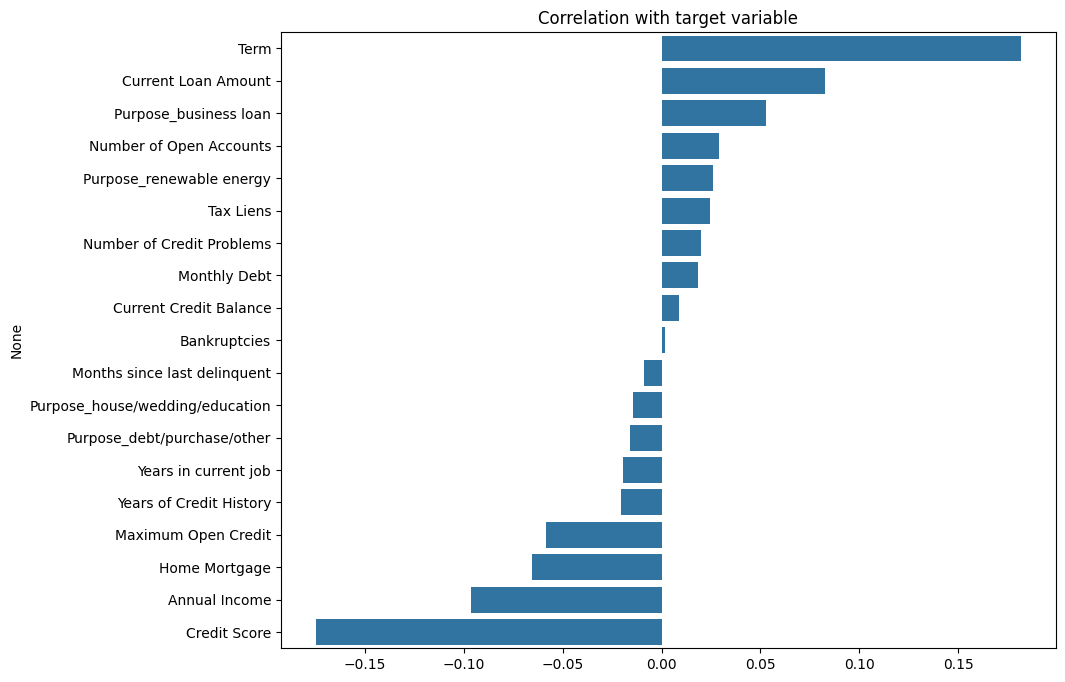

In [ ]:
corr_with_target = train_df[FEATURES_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')
plt.show()

In [ ]:
corr_with_target

Term                               0.181487
Current Loan Amount                0.082458
Purpose_business loan              0.052776
Number of Open Accounts            0.028884
Purpose_renewable energy           0.026078
Tax Liens                          0.024368
Number of Credit Problems          0.020088
Monthly Debt                       0.018221
Current Credit Balance             0.008972
Bankruptcies                       0.001640
Months since last delinquent      -0.008620
Purpose_house/wedding/education   -0.014257
Purpose_debt/purchase/other       -0.015896
Years in current job              -0.019342
Years of Credit History           -0.020567
Maximum Open Credit               -0.058236
Home Mortgage                     -0.065258
Annual Income                     -0.096429
Credit Score                      -0.174552
Name: Credit Default, dtype: float64

Можно увидеть, что наибольшее влияние на целевую переменную имеют признаки: Term (у долгосрочных кредитов больше просрочек), Credit Score (чем выше - тем меньше просрочек), Annual Income (чем выше - тем меньше просрочек) и Curernt Loan Amount (чем выше - тем больше просрочек).

### Оценка признака "Credit Score" в разрезе целевой переменной

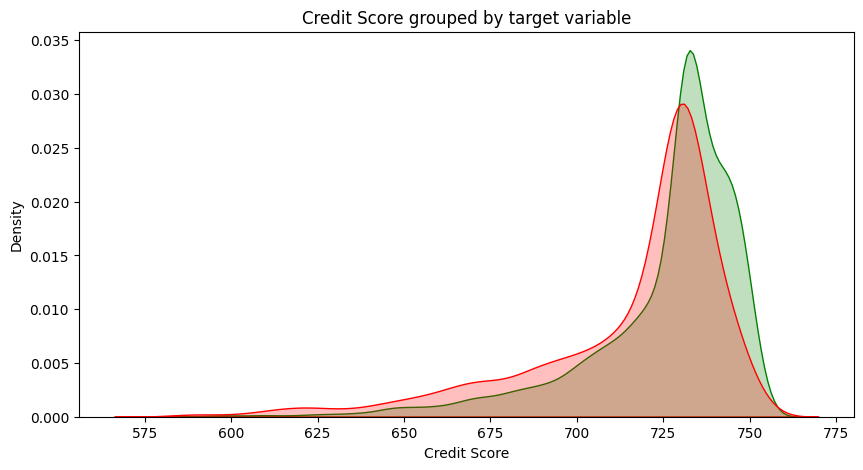

In [ ]:
cred_scor_with_target_s = train_df[['Credit Score', TARGET_NAME]]
cred_scor_s = cred_scor_with_target_s['Credit Score']
cred_scor_target_0 = cred_scor_s[cred_scor_with_target_s[TARGET_NAME] == 0]
cred_scor_target_1 = cred_scor_s[cred_scor_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(cred_scor_target_0, fill=True, label='No default', color='g')
sns.kdeplot(cred_scor_target_1, fill=True, label='Default', color='r')

plt.xlabel('Credit Score')
plt.title('Credit Score grouped by target variable')
plt.show()

**Наблюдение**

Похоже что две группы, полученные в результате разбиения признака "Credit Score" по целевой переменной, имеют различные распределения, что может помочь при построение модели, т.к. это будет означать, что между признаком "Credit Score" и целевой переменной, возможно, существует некоторая функциональная зависимость.

**Гипотеза**
* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий Стьюдента (t-тест) и его аналоги
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Чтобы проверить данную гипотезу сравним две выборки из рассматриваемых групп на предмет равенства средних значений.
Если вероятность того, что мат. ожидания в исходных группах равны при данных выборках, будет менее 5%, то можно будет говорить о том, что скорее всего выборки имеют различные распределения.

Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка

In [ ]:
shapiro(cred_scor_s)

ShapiroResult(statistic=0.8033861077239286, pvalue=2.883255861388269e-61)

По полученному значению p-value, которое сильно меньше 0.05, можем заключить, что гипотеза о "нормальности" отвергается.

Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.

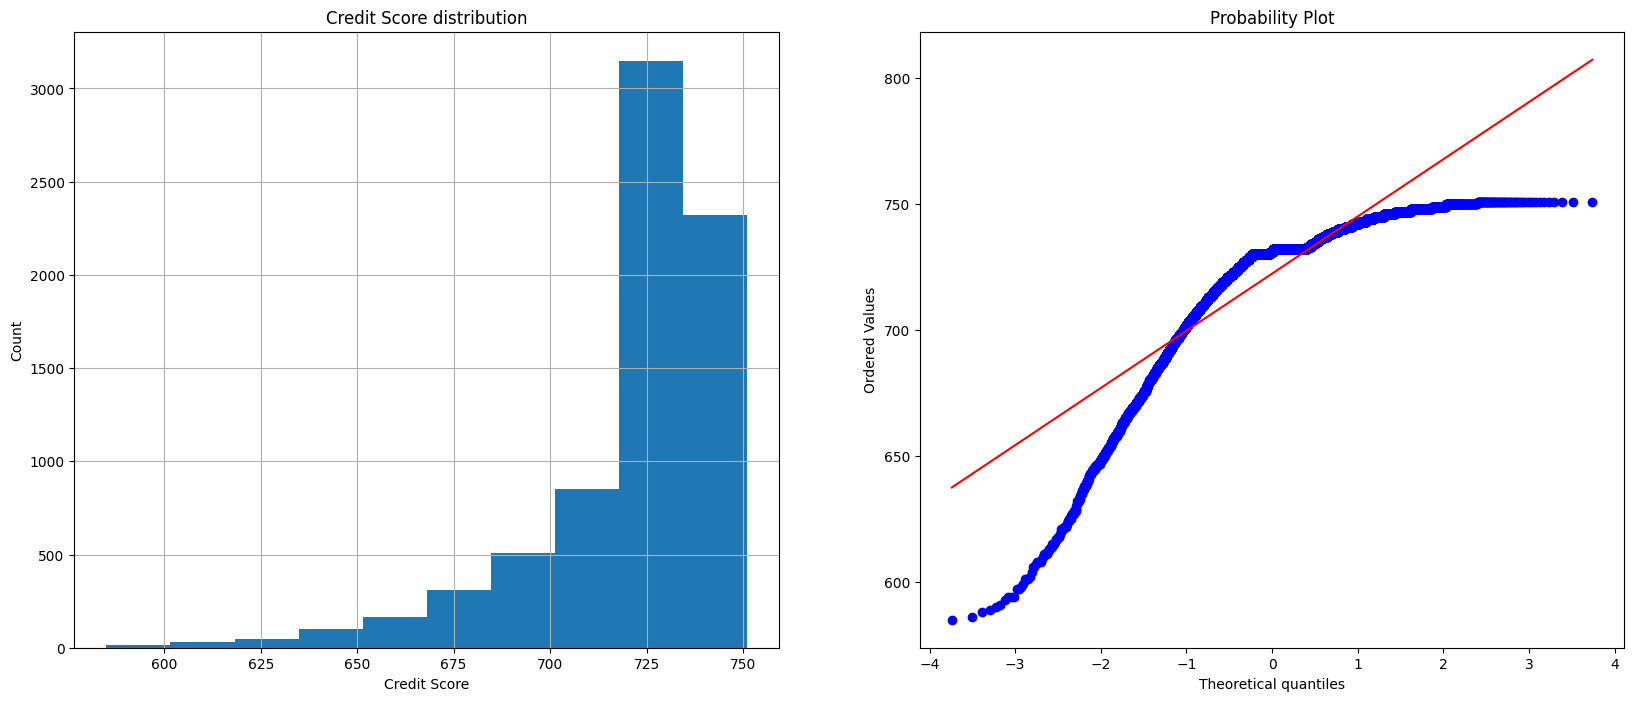

In [ ]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Credit Score')
ax1.set_ylabel('Count')
ax1.set_title('Credit Score distribution')
cred_scor_s.hist()

plt.subplot(122)
probplot(cred_scor_s, dist='norm', plot=plt)

plt.show()

Визуальная оценка подтверждает показания критерия Шапиро-Уилка по поводу того, что закон распределения отличный от "нормального", в связи с чем, мы не сможем воспользоваться критерием Стьюдента для проверки гипотезы о равности мат. ожиданий признака Credit Score в группах с просроченным и непросроченным платежом в следующем месяце, но мы сможем воспользоваться его непараметрическим аналогом - критерием Манна-Уитни, который не требователен к закону распределения.

Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни

In [ ]:
mannwhitneyu(cred_scor_target_0, cred_scor_target_1)

MannwhitneyuResult(statistic=7291634.5, pvalue=1.3090609384105415e-80)

Согласно значению p-value, гипотеза о равности мат. ожиданий отвергается, но стоит ради дополнительной проверки обратиться к доверительным интервалам.
Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их.


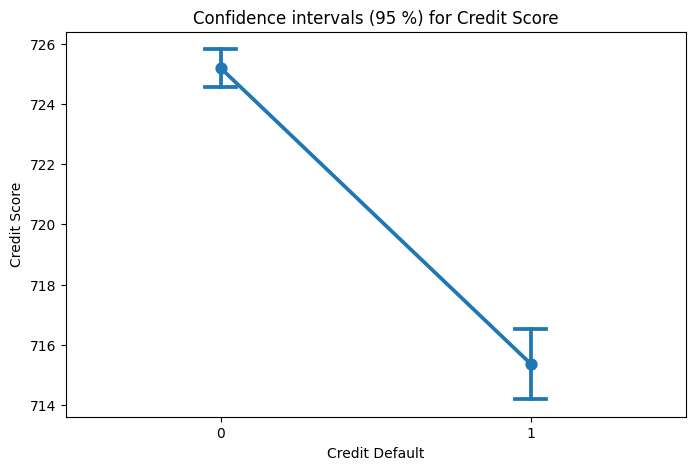

In [ ]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Credit Score', data=cred_scor_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Credit Score')
plt.show()

По данному графику так же видно, что интервалы, в которых с 95% вероятностью должны находится истинные мат. ожидания этих двух групп, не пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.

Это означает, что группы из которых взяты данные выборки, с допускаемой нами вероятностью (95%), имеют различные распределения и этот признак может быть полезен для определения значения целевой переменной.

### Оценка признака "Current Credit Balance" в разрезе целевой переменной

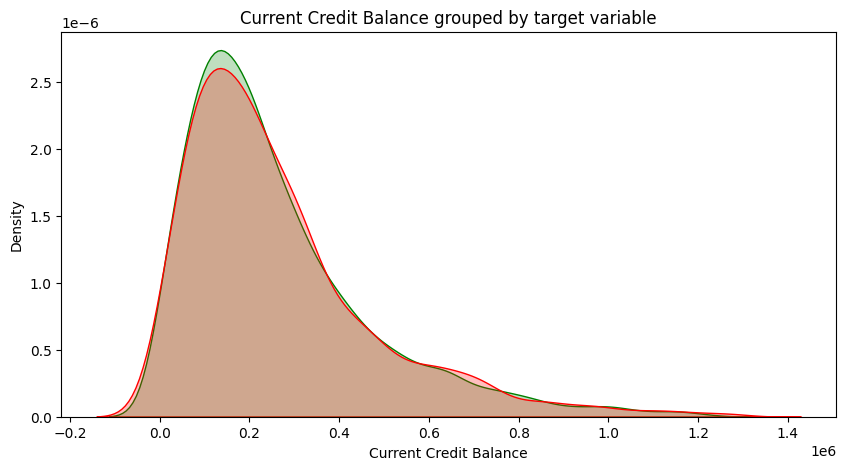

In [ ]:
feat_with_target_s = train_df[['Current Credit Balance', TARGET_NAME]]
feat_s = feat_with_target_s['Current Credit Balance']
feat_target_0 = feat_s[feat_with_target_s[TARGET_NAME] == 0]
feat_target_1 = feat_s[feat_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(feat_target_0, fill=True, label='No default', color='g')
sns.kdeplot(feat_target_1, fill=True, label='Default', color='r')

plt.xlabel('Current Credit Balance')
plt.title('Current Credit Balance grouped by target variable')
plt.show()

**Наблюдение**

Похоже что две группы, полученные в результате разбиения признака по целевой переменной, имеют схожие распределения, что может означать, что между признаком и целевой переменной отсутствует функциональная зависимость.

**Гипотеза**
* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий Стьюдента (t-тест) и его аналоги
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка

In [ ]:
shapiro(feat_s)

ShapiroResult(statistic=0.8686146406914341, pvalue=6.491197924804886e-54)

По полученному значению p-value, которое сильно меньше 0.05, можем заключить, что гипотеза о "нормальности" отвергается.

Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.

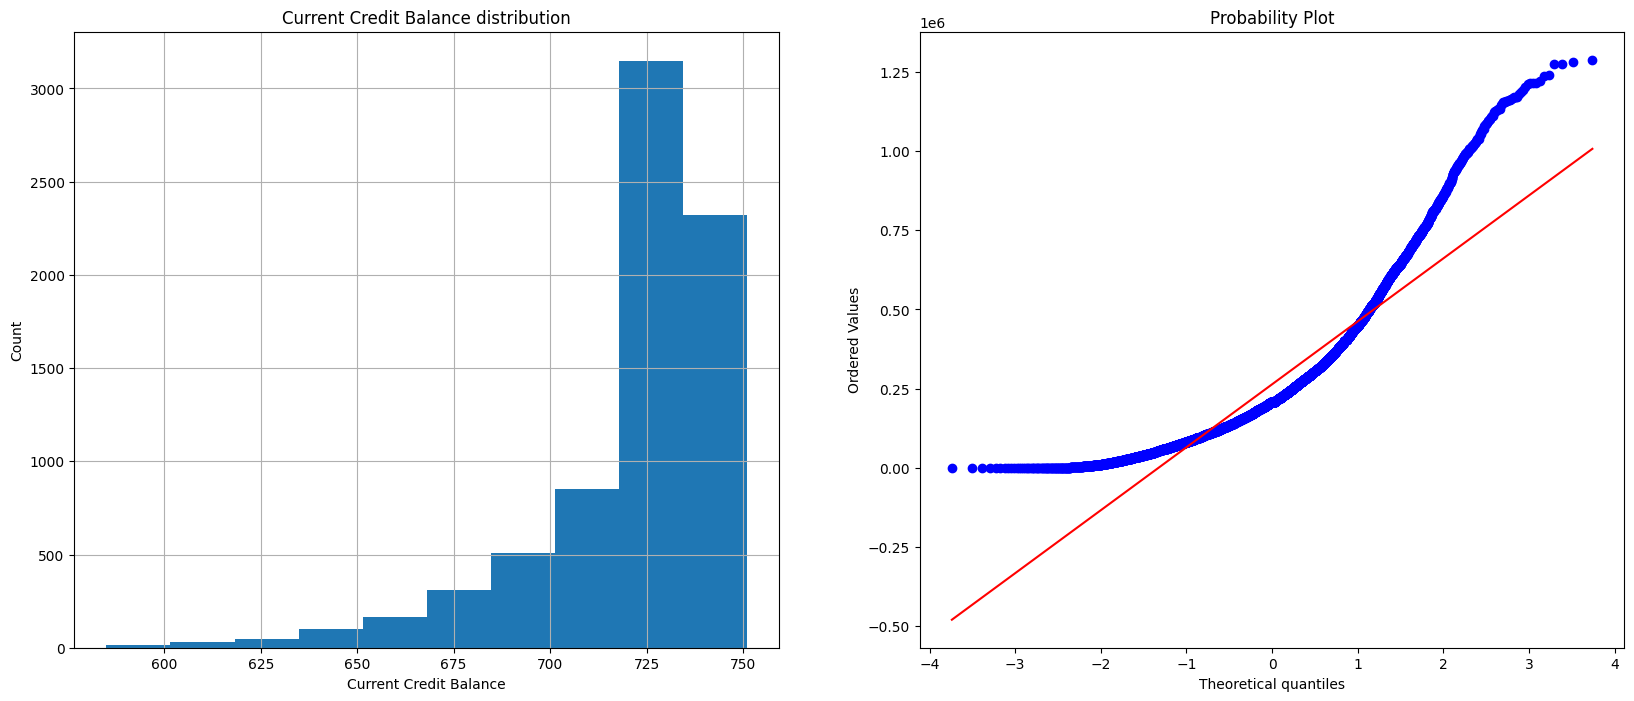

In [ ]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Current Credit Balance')
ax1.set_ylabel('Count')
ax1.set_title('Current Credit Balance distribution')
cred_scor_s.hist()

plt.subplot(122)
probplot(feat_s, dist='norm', plot=plt)

plt.show()

Визуальная оценка подтверждает показания критерия Шапиро-Уилка по поводу того, что закон распределения отличный от "нормального", в связи с чем, мы не сможем воспользоваться критерием Стьюдента для проверки гипотезы о равности мат. ожиданий признака в группах.
Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни

In [ ]:
mannwhitneyu(feat_target_0, feat_target_1)

MannwhitneyuResult(statistic=5644810.5, pvalue=0.5810083618989912)

Согласно значению p-value, гипотеза о равности мат. ожиданий принимается, но стоит ради дополнительной проверки обратиться к доверительным интервалам. Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их.

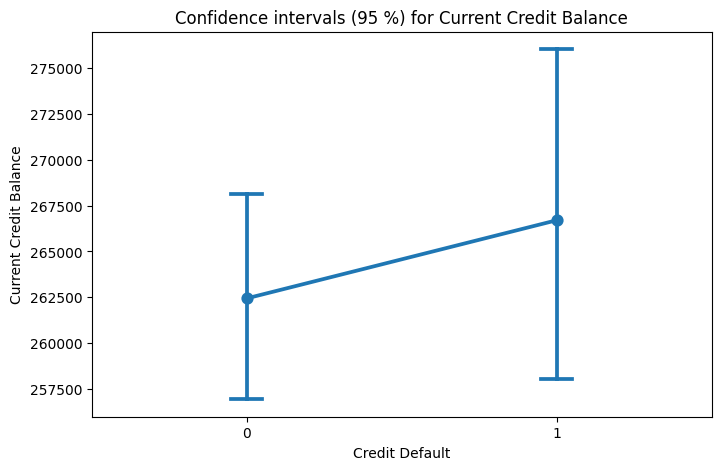

In [ ]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Current Credit Balance', data=feat_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Current Credit Balance')
plt.show()

По данному графику так же видно, что интервалы, в которых с 95% вероятностью должны находится истинные мат. ожидания этих двух групп, пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.

Это означает, что группы из которых взяты данные выборки, с допускаемой нами вероятностью (95%), имеют схожие распределения и этот признак может быть бесполезен для определения значения целевой переменной.

### Оценка признака "Annual Income" в разрезе целевой переменной

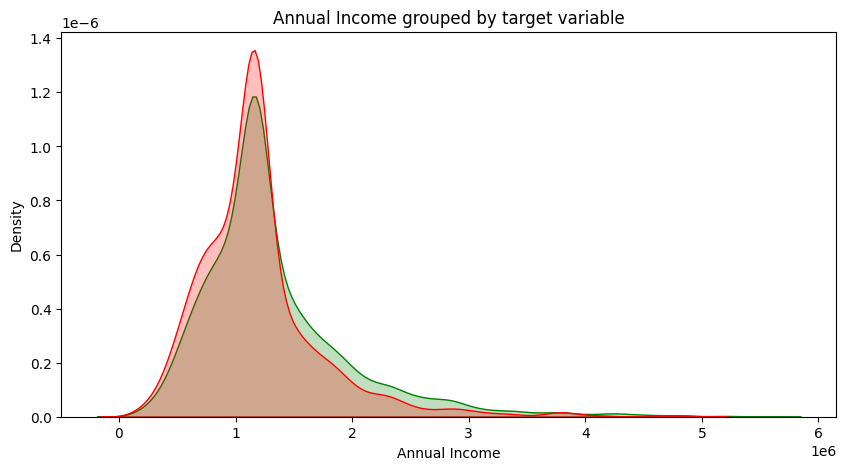

In [ ]:
feat_with_target_s = train_df[['Annual Income', TARGET_NAME]]
feat_s = feat_with_target_s['Annual Income']
feat_target_0 = feat_s[feat_with_target_s[TARGET_NAME] == 0]
feat_target_1 = feat_s[feat_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(feat_target_0, fill=True, label='No default', color='g')
sns.kdeplot(feat_target_1, fill=True, label='Default', color='r')

plt.xlabel('Annual Income')
plt.title('Annual Income grouped by target variable')
plt.show()

Проверим на нормальность

In [ ]:
shapiro(feat_s)

ShapiroResult(statistic=0.8492011589859496, pvalue=2.255062262590965e-56)

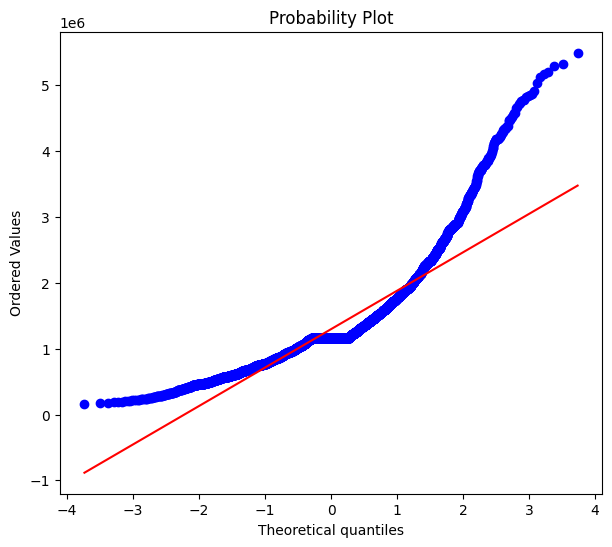

In [ ]:
plt.figure(figsize=(7, 6))

probplot(feat_s, dist='norm', plot=plt)

plt.show()

Распределение не нормальное, используем критерий Манна-Уитни.

In [ ]:
mannwhitneyu(feat_target_0, feat_target_1)

MannwhitneyuResult(statistic=6384824.0, pvalue=1.446857038752916e-16)

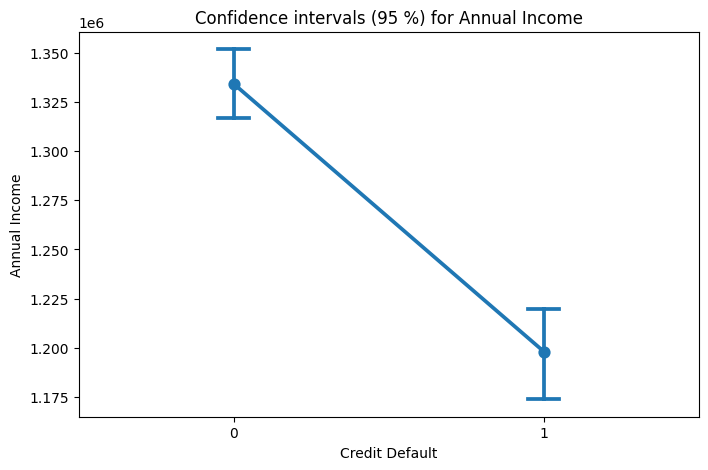

In [ ]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Annual Income', data=feat_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Annual Income')
plt.show()

По p-value и доверительным интервалам видно, что мат. ожидания не пересекаются, группы имеют различные распределения и признак может быть полезен для определения целевой переменной.

### Оценка признака "Monthly Debt" в разрезе целевой переменной

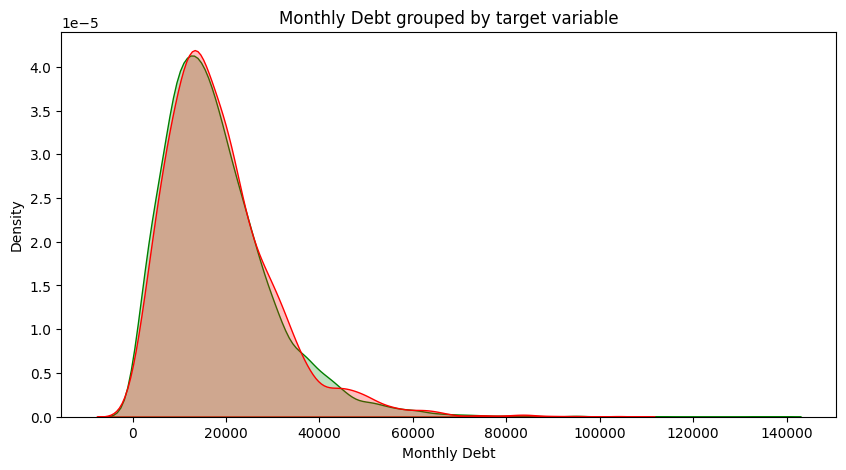

In [ ]:
feat_with_target_s = train_df[['Monthly Debt', TARGET_NAME]]
feat_s = feat_with_target_s['Monthly Debt']
feat_target_0 = feat_s[feat_with_target_s[TARGET_NAME] == 0]
feat_target_1 = feat_s[feat_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(feat_target_0, fill=True, label='No default', color='g')
sns.kdeplot(feat_target_1, fill=True, label='Default', color='r')

plt.xlabel('Monthly Debt')
plt.title('Monthly Debt grouped by target variable')
plt.show()

Распределения выглядят похожими. Проверим на нормальность.

In [ ]:
shapiro(feat_s)

ShapiroResult(statistic=0.8973899313296352, pvalue=1.2070614281613164e-49)

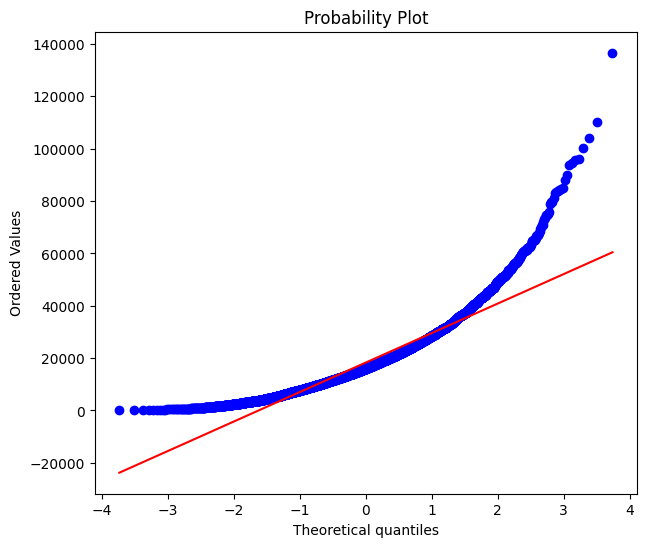

In [ ]:
plt.figure(figsize=(7, 6))

probplot(feat_s, dist='norm', plot=plt)

plt.show()

Распределение не нормальное, используем критерий Манна-Уитни.

In [ ]:
mannwhitneyu(feat_target_0, feat_target_1)

MannwhitneyuResult(statistic=5537386.5, pvalue=0.06793444936351892)

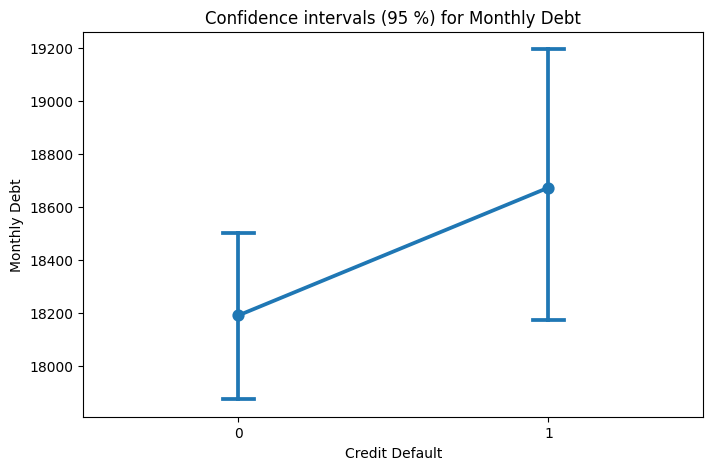

In [ ]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Monthly Debt', data=feat_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Monthly Debt')
plt.show()

Мат. ожидания пересекаются, распределения похожи, следовательно, не самый полезный признак.

В принципе, все эти выводы можно сделать по barplot'у корреляции целевой переменной с признаками (выше). Все результаты подтвердились, поэтому полезность остальных признаков можно смотреть по тому barplot'у.

### Анализ признакового пространства (матрица корреляций)

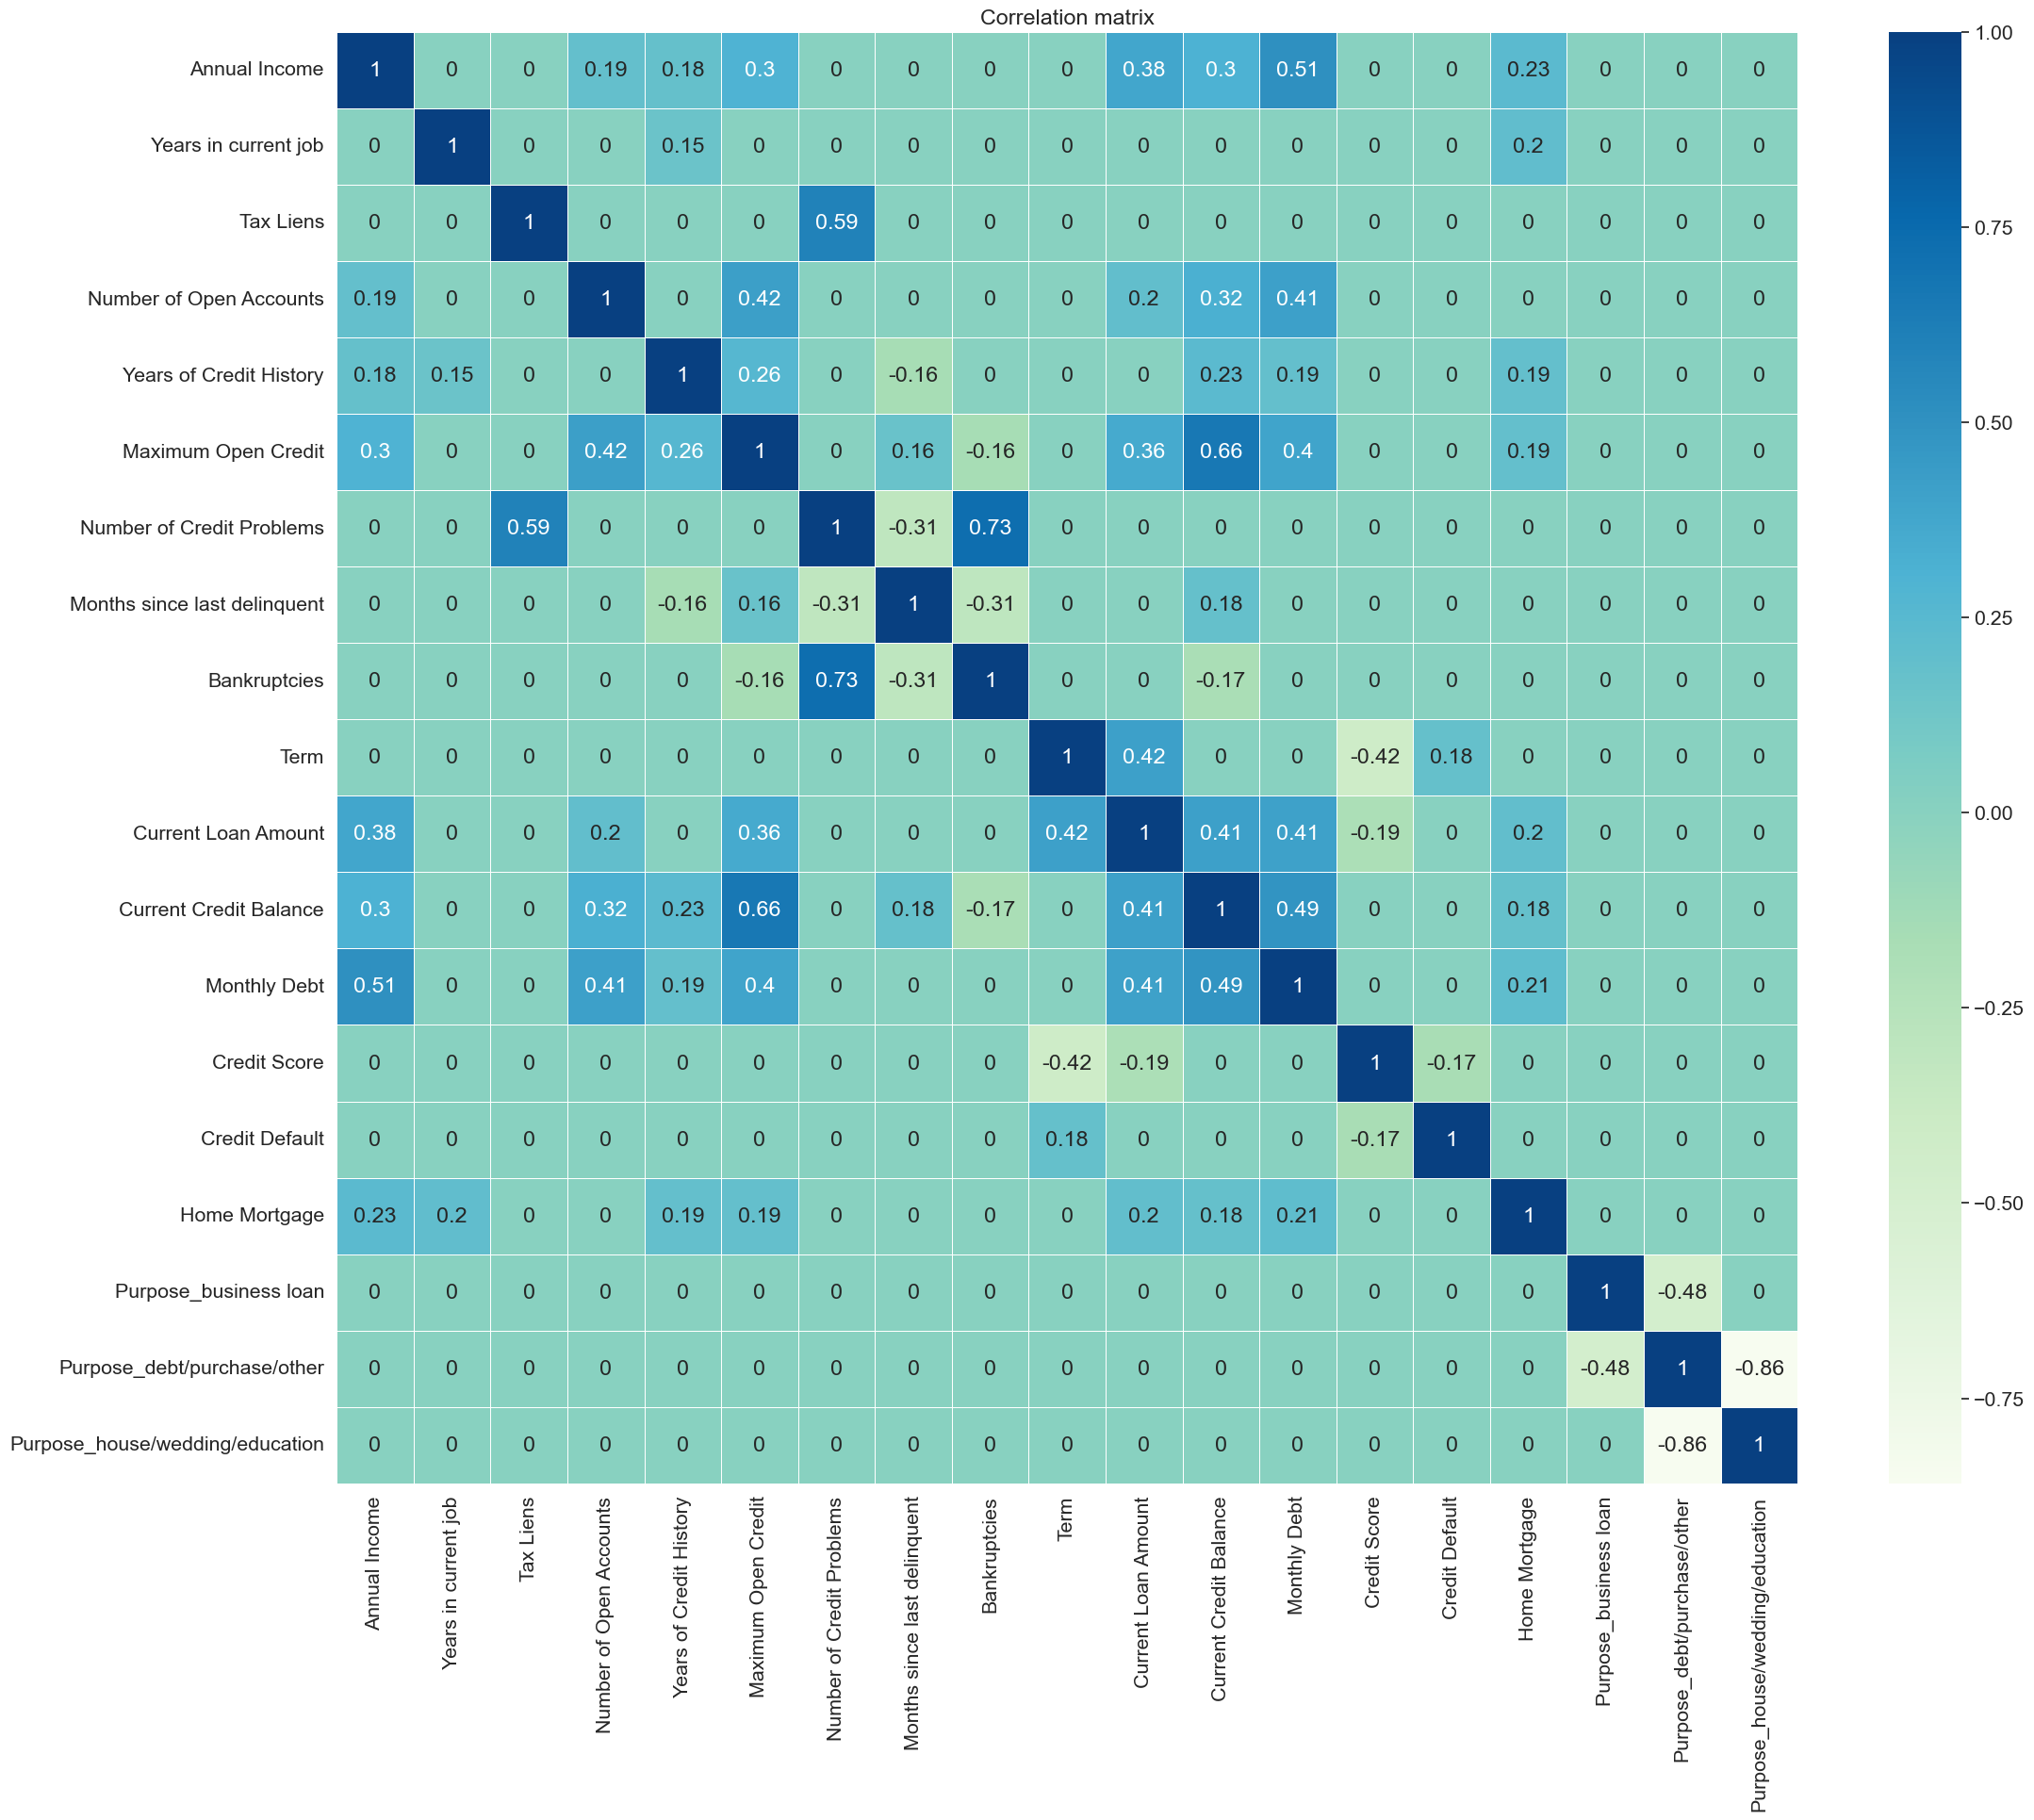

In [ ]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
corr_matrix = train_df.corr().round(3)
corr_matrix[np.abs(corr_matrix) < 0.15] = 0
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Можем заметить, что на целевую переменную Credit Default больше всего влияют признаки Term и Credit Score. Также можем видеть много признаков, которые имеют сильную корреляцию между собой, например: Purpose_debt/purchase/other и Purpose_house/wedding/education, Bankruptcies и Number of Credit Problems, и другие.

## 1.7. Отбор признаков

In [ ]:
train_df.columns

Index(['Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default', 'Home Mortgage',
       'Purpose_business loan', 'Purpose_debt/purchase/other',
       'Purpose_house/wedding/education'],
      dtype='object')

In [ ]:
TARGET_NAME = ['Credit Default']
NUM_FEATURE_NAMES = ['Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score']

CAT_FEATURE_NAMES = ['Term', 'Home Mortgage', 'Purpose_business loan', 'Purpose_debt/purchase/other', 'Purpose_house/wedding/education']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES

## 1.8. Нормализация данных

In [ ]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)

preprocessor = PreprocessingPipeline()

preprocessor.fit(train_df)
train_df = preprocessor.transform(train_df)

In [ ]:
scaler = StandardScaler()

train_df_norm = train_df.copy()
train_df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(train_df_norm[NUM_FEATURE_NAMES])

train_df = train_df_norm.copy()

### Сохранение модели для нормализации данных

In [ ]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

## 1.9. Балансировка классов

### Разбиение на test и valid

In [ ]:
X = train_df[SELECTED_FEATURE_NAMES]
y = train_df[TARGET_NAME]
train_df.shape, X.shape, y.shape

((7500, 20), (7500, 19), (7500, 1))

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=33)

In [ ]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((5625, 19), (1875, 19), (5625, 1), (1875, 1))

In [ ]:
y_train['Credit Default'].value_counts()

Credit Default
0    4042
1    1583
Name: count, dtype: int64

In [ ]:
ros = RandomOverSampler(random_state=33)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
y_resampled['Credit Default'].value_counts()

Credit Default
1    4042
0    4042
Name: count, dtype: int64

In [ ]:
X_train = X_resampled
y_train = y_resampled
X_train.shape, y_train.shape

((8084, 19), (8084, 1))

### Сохранение обучающей и валидационной выборки

In [ ]:
train = pd.concat([X_train, y_train], axis=1)
valid = pd.concat([X_valid, y_valid], axis=1)

train_df.to_csv(FULL_NORM_PATH, index=False, encoding='utf-8')
train.to_csv(BALANCED_TRAIN_PATH, index=False, encoding='utf-8')
valid.to_csv(VALID_PATH, index=False, encoding='utf-8')

## 1.10. Подбор моделей и настройка гиперпараметров

### Выводы по подбору моделей
* Логистическая регрессия, метод опорных векторов и k ближайших соседей показали плохие результаты.
* Можно попробовать настроить дерево решений и случайный лес
* Хорошие результаты показали бустинговые алгоритмы

### Настройка гиперпараметров

In [ ]:
ros = RandomOverSampler(random_state=33)
X_resampled, y_resampled = ros.fit_resample(X, y)
X = X_resampled
y = y_resampled
X.shape, y.shape

((10774, 19), (10774, 1))

In [ ]:
y = y.values.ravel()

#### Decision Tree Classifier

In [ ]:
# С использованием Oversampling
dt_classifier = DecisionTreeClassifier(random_state=33)

In [ ]:
cv=KFold(n_splits=5, random_state=33, shuffle=True)

In [ ]:
params = {'max_depth':[33, 66, 132],
          'min_samples_split':[2, 4, 8],
          'min_samples_leaf': [1, 2, 4],
          'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 7.5}, {0: 1, 1: 15}]
         }

In [ ]:
%%time

rs = RandomizedSearchCV(dt_classifier, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)
rs.best_params_, rs.best_score_

CPU times: total: 562 ms
Wall time: 10.8 s


({'min_samples_split': 4,
  'min_samples_leaf': 1,
  'max_depth': 66,
  'class_weight': {0: 1, 1: 7.5}},
 0.87641388858217)

#### Random Forest Classifier

In [ ]:
# С использованием Oversampling
rf_classifier = RandomForestClassifier(random_state=33)

In [ ]:
cv=KFold(n_splits=5, random_state=33, shuffle=True)

In [ ]:
params = {'n_estimators': [100, 200, 400],
          'max_depth':[22, 45, 90],
          'max_features': [2, 4, 10, 19],
          'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 1.92}, {0: 1, 1: 3.85}]
}

In [ ]:
%%time

rs = RandomizedSearchCV(rf_classifier, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)
rs.best_params_, rs.best_score_

CPU times: total: 8.39 s
Wall time: 1min 46s


({'n_estimators': 400,
  'max_features': 4,
  'max_depth': 45,
  'class_weight': {0: 1, 1: 1.92}},
 0.9082792123537345)

#### XGBoost

In [ ]:
# С использованием Oversampling
model_xgb = xgb.XGBClassifier(random_state=33)

In [ ]:
cv=KFold(n_splits=5, random_state=33, shuffle=True)

In [ ]:
params = {'n_estimators': [80, 161, 322],
          'learning_rate': [0.03, 0.063, 0.125],
          'max_depth': [86, 173, 346],
          'colsample_bytree': [0.21, 0.42, 0.84]
}

In [ ]:
%%time

rs = RandomizedSearchCV(model_xgb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)
rs.best_params_, rs.best_score_

CPU times: total: 28.1 s
Wall time: 1min 8s


({'n_estimators': 161,
  'max_depth': 346,
  'learning_rate': 0.03,
  'colsample_bytree': 0.42},
 0.9103710052466532)

#### LightGBM

In [ ]:
# С использованием Oversampling
model_lgbm = lgbm.LGBMClassifier(random_state=33, verbose=-1)

In [ ]:
cv=KFold(n_splits=5, random_state=33, shuffle=True)

In [ ]:
params = {'n_estimators': [87, 175, 350],
          'learning_rate': [0.035, 0.07, 0.14],
          'max_depth': [12, 24, 48],
          'num_leaves': [172, 350, 700],
          'min_child_samples': [2, 4, 8],
          'colsample_bytree': [0.2, 0.41, 0.82],
          'scale_pos_weight': [1, 1.25, 2.5]
}

In [ ]:
%%time

rs = RandomizedSearchCV(model_lgbm, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)
rs.best_params_, rs.best_score_

CPU times: total: 12.2 s
Wall time: 1min 40s


({'scale_pos_weight': 1,
  'num_leaves': 700,
  'n_estimators': 175,
  'min_child_samples': 2,
  'max_depth': 24,
  'learning_rate': 0.035,
  'colsample_bytree': 0.41},
 0.921946675961362)

In [ ]:
%%time

rs = RandomizedSearchCV(model_lgbm, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)
rs.best_params_, rs.best_score_

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5387, number of negative: 5387
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1811
[LightGBM] [Info] Number of data points in the train set: 10774, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

({'scale_pos_weight': 1.25,
  'num_leaves': 1230,
  'n_estimators': 175,
  'min_child_samples': 4,
  'max_depth': 24,
  'learning_rate': 0.07,
  'colsample_bytree': 0.41},
 0.9237175516521313)

#### CatBoost

In [ ]:
for colname in CAT_FEATURE_NAMES:
    X[colname] = pd.Categorical(X[colname])

X[CAT_FEATURE_NAMES].dtypes

Term                               category
Home Mortgage                      category
Purpose_business loan              category
Purpose_debt/purchase/other        category
Purpose_house/wedding/education    category
Purpose_renewable energy           category
dtype: object

In [ ]:
# С использованием Oversampling
model_catb = catb.CatBoostClassifier(silent=True, random_state=33, cat_features=CAT_FEATURE_NAMES)

In [ ]:
cv=KFold(n_splits=3, random_state=33, shuffle=True)

In [ ]:
params = {'n_estimators': [242, 484, 500],
          'learning_rate': [0.01, 0.02, 0.055, 0.09, 0.18],
          'depth': [4, 9, 12],
          'class_weights': [[1, 1], [1, 2.5], [1, 5]]
}

In [ ]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)
rs.best_params_, rs.best_score_

CPU times: total: 1min 10s
Wall time: 2min 38s


({'n_estimators': 484, 'learning_rate': 0.09, 'depth': 9}, 0.8836058432526225)

In [ ]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=1)
rs.fit(X, y)
rs.best_params_, rs.best_score_

CPU times: total: 44min 44s
Wall time: 8min 10s


({'n_estimators': 242,
  'learning_rate': 0.09,
  'depth': 12,
  'class_weights': [1, 1]},
 0.8734849766577849)

Настройка CatBoost занимает длительное время

### Выводы после настройки гиперпараметров
* Модели лучше работают с oversampling, чем без
* Худший результат показало Decision Tree - 87,64%.
* У CatBoost удалось получить 88,36%, для дальнейшей настройки у меня не хватает оперативной памяти.
* Лучшие результаты: LightGBM (92.19%), XGBoost (91.04%), RandomForestClassifier (90.83%).

## 1.11. Проверка качества и борьба с переобучением

In [ ]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
X = train_df
y = train_df[TARGET_NAME]
train_df.shape, X.shape, y.shape

((7500, 17), (7500, 17), (7500, 1))

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=33)
X_valid = X_valid.drop(TARGET_NAME, axis=1)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((5625, 17), (1875, 16), (5625, 1), (1875, 1))

In [ ]:
preprocessor = PreprocessingPipeline()
preprocessor.fit(X_train)
X_train = X_train.drop(TARGET_NAME, axis=1)
X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train[NUM_FEATURE_NAMES])
X_train[NUM_FEATURE_NAMES] = scaler.transform(X_train[NUM_FEATURE_NAMES])
X_valid[NUM_FEATURE_NAMES] = scaler.transform(X_valid[NUM_FEATURE_NAMES])

In [ ]:
ros = RandomOverSampler(random_state=33)
X_train, y_train = ros.fit_resample(X_train, y_train)
y_train['Credit Default'].value_counts()

Credit Default
1    4042
0    4042
Name: count, dtype: int64

In [ ]:
X_train.shape, X_valid.shape

((8084, 18), (1875, 18))

In [ ]:
y_train = y_train.values.ravel()
y_valid = y_valid.values.ravel()

### Проверка качества

In [ ]:
%%time

dt_classifier = DecisionTreeClassifier(random_state=33,
                                       min_samples_split=2,
                                       min_samples_leaf=1,
                                       max_depth=66,
                                       class_weight={0: 1, 1: 7.5})

dt_classifier.fit(X_train, y_train)

y_train_pred = dt_classifier.predict(X_train)
y_valid_pred = dt_classifier.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4042
           1       1.00      1.00      1.00      4042

    accuracy                           1.00      8084
   macro avg       1.00      1.00      1.00      8084
weighted avg       1.00      1.00      1.00      8084

VALID

              precision    recall  f1-score   support

           0       0.75      0.77      0.76      1345
           1       0.38      0.35      0.36       530

    accuracy                           0.65      1875
   macro avg       0.56      0.56      0.56      1875
weighted avg       0.64      0.65      0.65      1875

CONFUSION MATRIX

col_0     0    1
row_0           
0      1035  310
1       344  186
CPU times: total: 188 ms
Wall time: 187 ms


In [ ]:
%%time

rf_classifier = RandomForestClassifier(random_state=33,
                                       n_estimators=400,
                                       max_features=2,
                                       max_depth=45,
                                       class_weight={0: 1, 1: 1.92})
rf_classifier.fit(X_train, y_train)

y_train_pred = rf_classifier.predict(X_train)
y_valid_pred = rf_classifier.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4042
           1       1.00      1.00      1.00      4042

    accuracy                           1.00      8084
   macro avg       1.00      1.00      1.00      8084
weighted avg       1.00      1.00      1.00      8084

VALID

              precision    recall  f1-score   support

           0       0.75      0.90      0.82      1345
           1       0.48      0.23      0.31       530

    accuracy                           0.71      1875
   macro avg       0.62      0.57      0.57      1875
weighted avg       0.67      0.71      0.68      1875

CONFUSION MATRIX

col_0     0    1
row_0           
0      1215  130
1       408  122
CPU times: total: 5.41 s
Wall time: 5.63 s


In [ ]:
%%time

model_xgb = xgb.XGBClassifier(random_state=33,
                              n_estimators=161,
                              max_depth=173,
                              learning_rate=0.063,
                              colsample_bytree=0.42,
                             scale_pos_weight=2)

model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_valid_pred = model_xgb.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4042
           1       1.00      1.00      1.00      4042

    accuracy                           1.00      8084
   macro avg       1.00      1.00      1.00      8084
weighted avg       1.00      1.00      1.00      8084

VALID

              precision    recall  f1-score   support

           0       0.75      0.84      0.79      1345
           1       0.42      0.29      0.34       530

    accuracy                           0.69      1875
   macro avg       0.59      0.57      0.57      1875
weighted avg       0.66      0.69      0.67      1875

CONFUSION MATRIX

col_0     0    1
row_0           
0      1131  214
1       375  155
CPU times: total: 19.9 s
Wall time: 2.72 s


In [ ]:
%%time

model_lgbm = lgbm.LGBMClassifier(random_state=33, verbose=-1,
                                 scale_pos_weight=1.25,
                                 num_leaves=1230,
                                 n_estimators=175,
                                 min_child_samples=4,
                                 max_depth=24,
                                 learning_rate=0.07,
                                 colsample_bytree=0.41)

model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_valid_pred = model_lgbm.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4042
           1       1.00      1.00      1.00      4042

    accuracy                           1.00      8084
   macro avg       1.00      1.00      1.00      8084
weighted avg       1.00      1.00      1.00      8084

VALID

              precision    recall  f1-score   support

           0       0.74      0.95      0.83      1345
           1       0.52      0.14      0.22       530

    accuracy                           0.72      1875
   macro avg       0.63      0.54      0.52      1875
weighted avg       0.67      0.72      0.66      1875

CONFUSION MATRIX

col_0     0   1
row_0          
0      1276  69
1       456  74
CPU times: total: 16.4 s
Wall time: 4.26 s


In [ ]:
for colname in CAT_FEATURE_NAMES:
    X_train[colname] = pd.Categorical(X_train[colname])
    X_valid[colname] = pd.Categorical(X_valid[colname])

X_train[CAT_FEATURE_NAMES].dtypes, X_valid[CAT_FEATURE_NAMES].dtypes

(Term                               category
 Home Mortgage                      category
 Purpose_business loan              category
 Purpose_debt/purchase/other        category
 Purpose_house/wedding/education    category
 dtype: object,
 Term                               category
 Home Mortgage                      category
 Purpose_business loan              category
 Purpose_debt/purchase/other        category
 Purpose_house/wedding/education    category
 dtype: object)

In [ ]:
%%time

model_catb = catb.CatBoostClassifier(silent=True, random_state=33, cat_features=CAT_FEATURE_NAMES,
                                 n_estimators=484,
                                     learning_rate=0.09,
                                     depth=9)

model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_valid_pred = model_catb.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4042
           1       1.00      1.00      1.00      4042

    accuracy                           1.00      8084
   macro avg       1.00      1.00      1.00      8084
weighted avg       1.00      1.00      1.00      8084

VALID

              precision    recall  f1-score   support

           0       0.77      0.83      0.80      1345
           1       0.45      0.36      0.40       530

    accuracy                           0.69      1875
   macro avg       0.61      0.59      0.60      1875
weighted avg       0.68      0.69      0.68      1875

CONFUSION MATRIX

col_0     0    1
row_0           
0      1114  231
1       341  189
CPU times: total: 42.6 s
Wall time: 7.92 s


Результаты у первого класса не очень. Модели сильно переобучаются.

### Снижение степени переобучения

In [ ]:
%%time

coeff = [1]
for i in coeff:
    dt_classifier = DecisionTreeClassifier(random_state=33,
                                       # min_samples_split=i,
                                       # min_samples_leaf=i,
                                       max_depth=5,
                                       # max_features=i,
                                       # class_weight={0: 1, 1: i}
                                          )

    dt_classifier.fit(X_train, y_train)
    # y_train_pred = dt_classifier.predict(X_train)
    y_valid_pred = dt_classifier.predict(X_valid)

    print(classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.77      0.70      0.73      1345
           1       0.39      0.48      0.43       530

    accuracy                           0.64      1875
   macro avg       0.58      0.59      0.58      1875
weighted avg       0.66      0.64      0.65      1875

CPU times: total: 62.5 ms
Wall time: 59.8 ms


In [ ]:
%%time

coeff = [1]
for i in coeff:
    rf_classifier = RandomForestClassifier(random_state=33,
                                       n_estimators=250,
                                       max_features=4,
                                       max_depth=12,
                                       # min_samples_split=i,
                                       # min_samples_leaf=i,
                                       # class_weight={0: 1, 1: i},
                                          )
    rf_classifier.fit(X_train, y_train)

    # y_train_pred = rf_classifier.predict(X_train)
    y_valid_pred = rf_classifier.predict(X_valid)

    print(classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.78      0.77      0.77      1345
           1       0.44      0.46      0.45       530

    accuracy                           0.68      1875
   macro avg       0.61      0.61      0.61      1875
weighted avg       0.68      0.68      0.68      1875

CPU times: total: 3.17 s
Wall time: 3.17 s


In [ ]:
%%time

coeff = [1]
for i in coeff:
    model_xgb = xgb.XGBClassifier(random_state=33,
                              n_estimators=18,
                              max_depth=9,
                              learning_rate=0.2,
                              # subsample=i,
                              # colsample_bytree=i,
                                  gamma=0.01,
                                  # reg_alpha=i,
                                  # reg_lambda=i
                              # scale_pos_weight=i
                                 )

    model_xgb.fit(X_train, y_train)

    # y_train_pred = model_xgb.predict(X_train)
    y_valid_pred = model_xgb.predict(X_valid)

    print(classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.78      0.75      0.77      1345
           1       0.43      0.47      0.45       530

    accuracy                           0.67      1875
   macro avg       0.60      0.61      0.61      1875
weighted avg       0.68      0.67      0.68      1875

CPU times: total: 750 ms
Wall time: 119 ms


In [ ]:
%%time

coeff = [ 0]
for i in coeff:
    model_lgbm = lgbm.LGBMClassifier(random_state=33,
                                     verbose=-1,
                                 # scale_pos_weight=i,
                                 num_leaves=60,
                                 n_estimators=80,
                                 # min_data_in_leaf=i,
                                 max_depth=27,
                                 # learning_rate=i,
                                 # feature_fraction=i,
                                     # bagging_fraction=i
                                 # reg_alpha=i,
                                 # reg_lambda=i
                                    )

    model_lgbm.fit(X_train, y_train)

    # y_train_pred = model_lgbm.predict(X_train)
    y_valid_pred = model_lgbm.predict(X_valid)

    print(classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.79      0.77      0.78      1345
           1       0.45      0.47      0.46       530

    accuracy                           0.69      1875
   macro avg       0.62      0.62      0.62      1875
weighted avg       0.69      0.69      0.69      1875

CPU times: total: 703 ms
Wall time: 183 ms


In [ ]:
for colname in CAT_FEATURE_NAMES:
    X_train[colname] = pd.Categorical(X_train[colname])
    X_valid[colname] = pd.Categorical(X_valid[colname])

X_train[CAT_FEATURE_NAMES].dtypes, X_valid[CAT_FEATURE_NAMES].dtypes

(Term                               category
 Home Mortgage                      category
 Purpose_business loan              category
 Purpose_debt/purchase/other        category
 Purpose_house/wedding/education    category
 dtype: object,
 Term                               category
 Home Mortgage                      category
 Purpose_business loan              category
 Purpose_debt/purchase/other        category
 Purpose_house/wedding/education    category
 dtype: object)

In [ ]:
%%time

coeff = [3]
for i in coeff:
    model_catb = catb.CatBoostClassifier(silent=True, random_state=33, cat_features=CAT_FEATURE_NAMES,
                                 n_estimators=375,
                                         learning_rate=0.015,
                                 # depth=i,
                                 # l2_leaf_reg=i
                                        )

    model_catb.fit(X_train, y_train)

    # y_train_pred = model_catb.predict(X_train)
    y_valid_pred = model_catb.predict(X_valid)

    print(classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.81      0.64      0.72      1345
           1       0.41      0.63      0.49       530

    accuracy                           0.64      1875
   macro avg       0.61      0.63      0.61      1875
weighted avg       0.70      0.64      0.65      1875

CPU times: total: 9.44 s
Wall time: 2.14 s


### Выводы
Самые лучшие показатели по первому классу у  LightGBM: 0.45      0.47      0.46.


## 1.12. Выбор наилучшей модели

In [ ]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)

X = train_df
y = train_df[TARGET_NAME]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=33)
X_valid = X_valid.drop(TARGET_NAME, axis=1)

preprocessor = PreprocessingPipeline()
preprocessor.fit(X_train)
X_train = X_train.drop(TARGET_NAME, axis=1)
X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)

scaler = StandardScaler()
scaler.fit(X_train[NUM_FEATURE_NAMES])
X_train[NUM_FEATURE_NAMES] = scaler.transform(X_train[NUM_FEATURE_NAMES])
X_valid[NUM_FEATURE_NAMES] = scaler.transform(X_valid[NUM_FEATURE_NAMES])

ros = RandomOverSampler(random_state=33)
X_train, y_train = ros.fit_resample(X_train, y_train)

y_train = y_train.values.ravel()
y_valid = y_valid.values.ravel()

In [ ]:
# Пробовала убирать признаки - только хуже получается
# drop = 'Purpose_house/wedding/education'
# X_train = X_train.drop([drop], axis=1)
# X_valid = X_valid.drop([drop], axis=1)

In [ ]:
%%time

coeff = [0]
for i in coeff:
    model_lgbm = lgbm.LGBMClassifier(random_state=33,
                                     verbose=-1,
                                 # # scale_pos_weight=i,
                                 num_leaves=60,
                                 n_estimators=75,
                                 # min_data_in_leaf=i,
                                 max_depth=27,
                                     # min_split_gain=10
                                 # learning_rate=0.1,
                                 # feature_fraction=0.85,
                                  # bagging_fraction=i
                                 # reg_alpha=5,
                                 # reg_lambda=0
                                    )

    model_lgbm.fit(X_train, y_train)

    y_train_pred = model_lgbm.predict(X_train)
    y_valid_pred = model_lgbm.predict(X_valid)

    print(get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred))

TRAIN

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      4042
           1       0.94      0.98      0.96      4042

    accuracy                           0.96      8084
   macro avg       0.96      0.96      0.96      8084
weighted avg       0.96      0.96      0.96      8084

VALID

              precision    recall  f1-score   support

           0       0.79      0.77      0.78      1345
           1       0.45      0.47      0.46       530

    accuracy                           0.68      1875
   macro avg       0.62      0.62      0.62      1875
weighted avg       0.69      0.68      0.69      1875

CONFUSION MATRIX

col_0     0    1
row_0           
0      1032  313
1       279  251
None
CPU times: total: 1.14 s
Wall time: 3.57 s


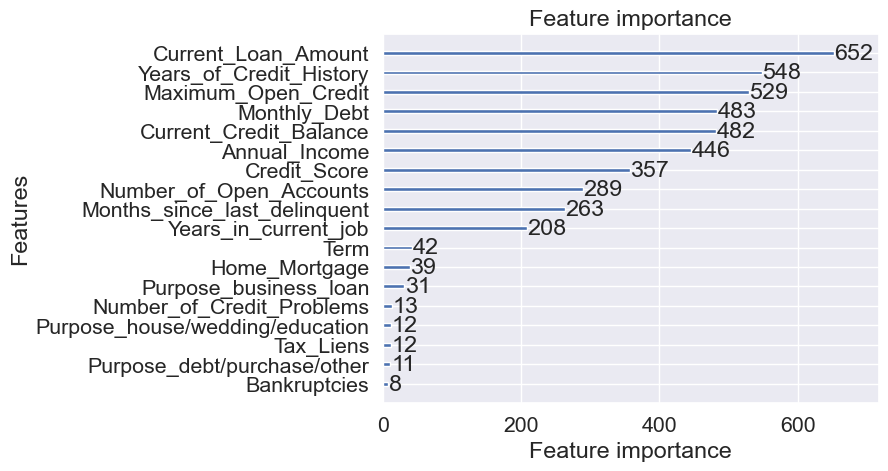

In [ ]:
plot_importance(model_lgbm, importance_type='split')
plt.show()

## 1.13. Интерпретация результатов

### Подбор оптимального размера выборки, кривая обучения

In [ ]:
model_lgbm = lgbm.LGBMClassifier(random_state=33,
                                     verbose=-1,
                                 # # scale_pos_weight=i,
                                 num_leaves=60,
                                 n_estimators=75,
                                 # min_data_in_leaf=i,
                                 max_depth=27
                                    )

In [ ]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y,
                                                            cv=cv,
                                                            scoring='f1',
                                                            train_sizes=train_sizes,
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [ ]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)

preprocessor = PreprocessingPipeline()
preprocessor.fit(train_df)

train_df = preprocessor.transform(train_df)

In [ ]:
X = train_df.drop(TARGET_NAME, axis=1)
y = train_df[TARGET_NAME]


In [ ]:
ros = RandomOverSampler(random_state=33)
X_resampled, y_resampled = ros.fit_resample(X, y)
X = X_resampled
y = y_resampled
X.shape, y.shape

((10774, 18), (10774, 1))

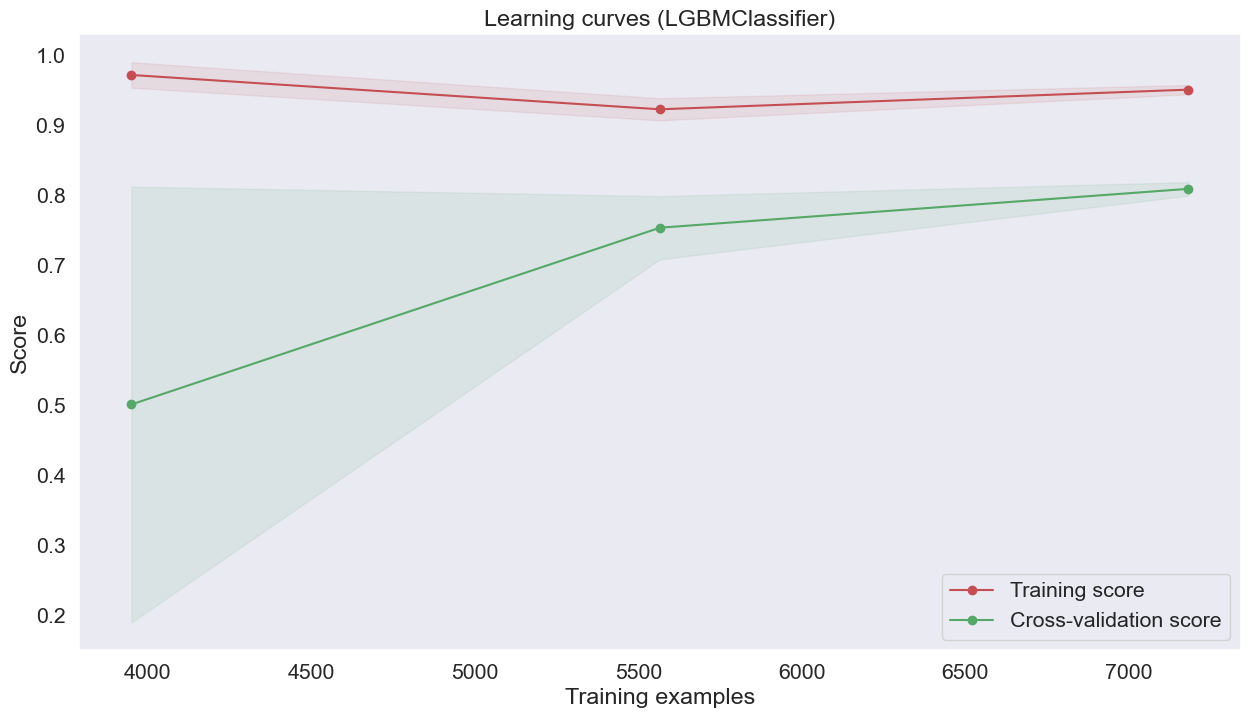

In [ ]:
show_learning_curve_plot(model_lgbm, X, y)

Самое высокое значение достигается при максимальной выборке

### Выбор порога вероятности для определения класса

In [ ]:
model_lgbm.fit(X_train, y_train)

# y_valid_pred = model_lgbm.predict(X_valid)
y_valid_pred_probs = model_lgbm.predict_proba(X_valid)

In [ ]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)

    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns,
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0],
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0],
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

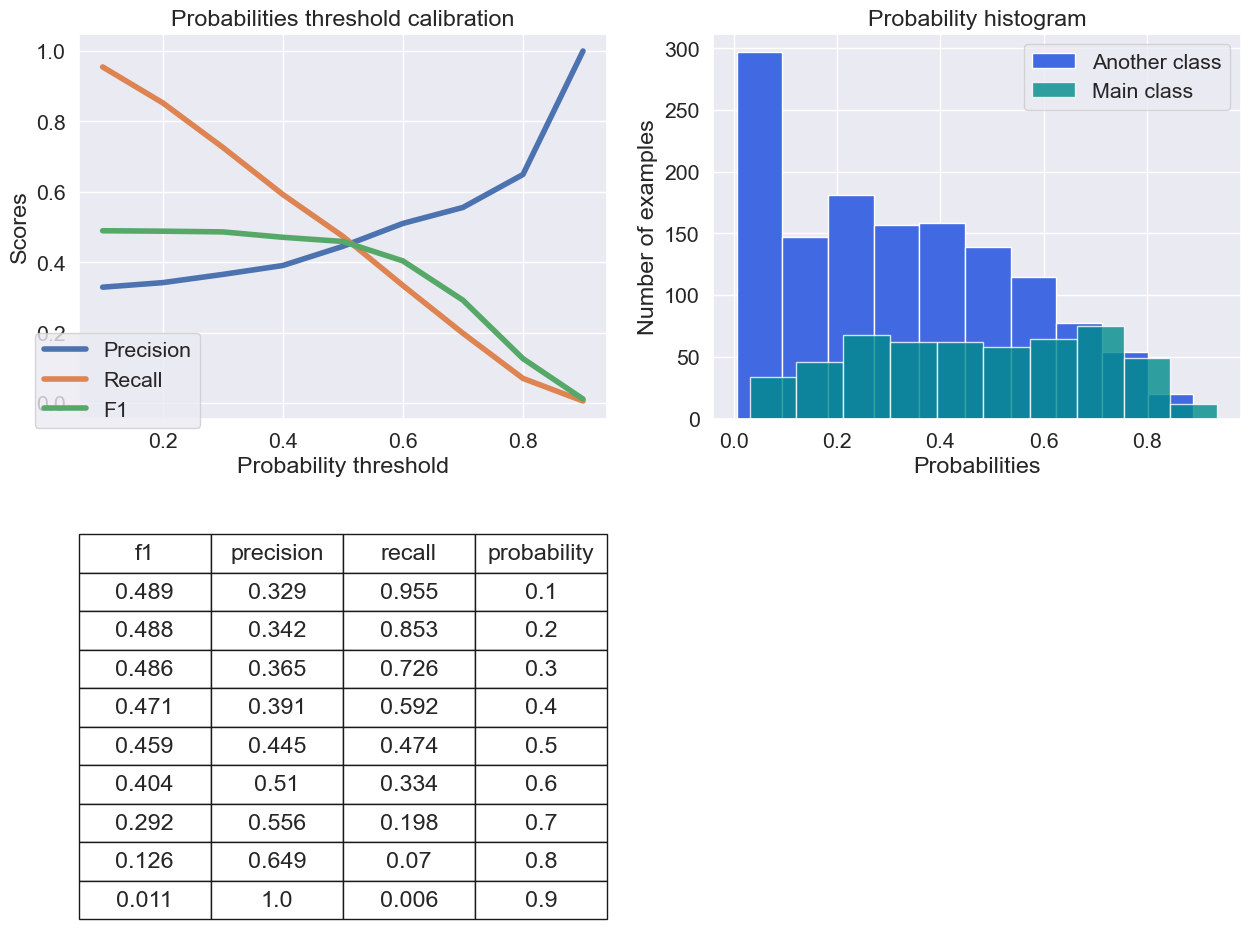

In [ ]:
show_proba_calibration_plots(y_valid_pred_probs[:, 1], y_valid)

0.5 - лучший порог вероятности

### Важность признаков

In [ ]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)

    plt.figure(figsize = (20, len(feature_importances) * 0.355))

    sns.barplot(x='importance', y='feature', data=feature_importances)

    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()

    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

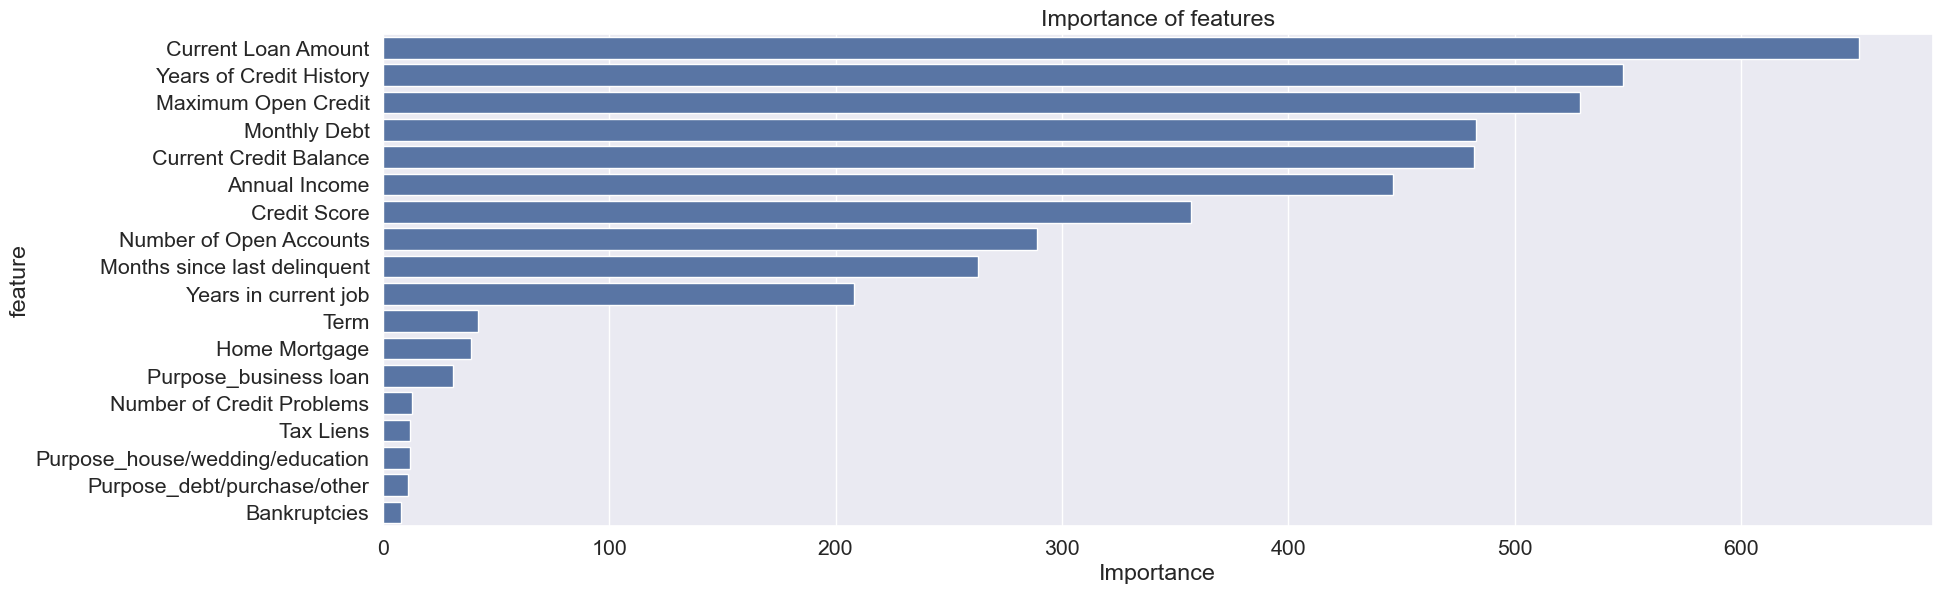

In [ ]:
important_features_top = show_feature_importances(X_train.columns, model_lgbm.feature_importances_, get_top=15)

In [ ]:
important_features_top

['Current Loan Amount',
 'Years of Credit History',
 'Maximum Open Credit',
 'Monthly Debt',
 'Current Credit Balance',
 'Annual Income',
 'Credit Score',
 'Number of Open Accounts',
 'Months since last delinquent',
 'Years in current job',
 'Term',
 'Home Mortgage',
 'Purpose_business loan',
 'Number of Credit Problems',
 'Tax Liens']

Признаки Bankruptcies, Purpose_house/wedding/education, Purpose_debt/purchase/other и Tax Liens имеют наименьшую значимость, их можно попробовать убрать.

# 2. Прогнозирование на тестовом датасэте

In [ ]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)
train_df.shape, test_df.shape

((7500, 17), (2500, 16))

In [ ]:
X_train = train_df.drop(TARGET_NAME, axis=1)
y_train = train_df[TARGET_NAME]
X_test = test_df

X_train.shape, y_train.shape, X_test.shape

((7500, 16), (7500, 1), (2500, 16))

In [ ]:
preprocessor = PreprocessingPipeline()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

X_train.shape, X_test.shape

((7500, 18), (2500, 18))

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train[NUM_FEATURE_NAMES])
X_train[NUM_FEATURE_NAMES] = scaler.transform(X_train[NUM_FEATURE_NAMES])
X_test[NUM_FEATURE_NAMES] = scaler.transform(X_test[NUM_FEATURE_NAMES])
X_test.sample(5)

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Home Mortgage,Purpose_business loan,Purpose_debt/purchase/other,Purpose_house/wedding/education
115,-1.014172,-0.439911,-0.110953,0.380774,-1.067598,-0.674000,-0.340979,1.043669,-0.337099,1,-0.724821,-0.472179,-0.614721,-0.686546,0,0,1,0
958,-1.157532,1.182380,-0.110953,-1.045295,-0.613148,-0.215537,-0.340979,1.043669,-0.337099,0,-0.524704,0.207584,-0.904275,0.539956,1,0,1,0
1769,-0.362661,1.182380,-0.110953,1.195671,-0.272310,-0.914992,1.664779,-0.962504,2.545732,1,-0.234253,-1.063688,0.517981,-3.218679,0,0,1,0
1442,-0.149115,1.182380,-0.110953,-1.045295,1.034234,-0.859722,-0.340979,1.043669,-0.337099,0,-0.986738,-0.545650,-0.681360,0.460827,1,0,0,1
545,-0.089501,-0.169529,-0.110953,0.584498,0.977428,1.509409,-0.340979,1.043669,-0.337099,0,-0.222098,-0.097610,-0.351017,1.014731,1,0,1,0


In [ ]:
y_train.value_counts()

Credit Default
0                 5387
1                 2113
Name: count, dtype: int64

In [ ]:
ros = RandomOverSampler(random_state=33)
X_train, y_train = ros.fit_resample(X_train, y_train)
y_train.value_counts(), X_train.shape

(Credit Default
 0                 5387
 1                 5387
 Name: count, dtype: int64,
 (10774, 18))

In [ ]:
y_train = y_train.values.ravel()

In [ ]:
final_model = lgbm.LGBMClassifier(random_state=33,
                                     verbose=-1,
                                 num_leaves=60,
                                 n_estimators=75,
                                 max_depth=27,
                                    )

final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

print('TRAIN\n\n' + classification_report(y_train, y_train_pred))

TRAIN

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      5387
           1       0.91      0.96      0.93      5387

    accuracy                           0.93     10774
   macro avg       0.93      0.93      0.93     10774
weighted avg       0.93      0.93      0.93     10774



In [ ]:
y_test_pred

array([0, 1, 0, ..., 0, 0, 1], dtype=int64)

In [ ]:
predictions_df = pd.DataFrame(y_test_pred)
predictions_df

,0
0,0
1,1
2,0
3,0
4,0
...,...
2495,0
2496,0
2497,0
2498,0


In [ ]:
predictions_df.to_csv('YuKhismatullina_predictions.csv', index=False)

In [ ]:
df = pd.read_csv('YuKhismatullina_predictions.csv')
df

,0
0,0
1,1
2,0
3,0
4,0
...,...
2495,0
2496,0
2497,0
2498,0
